In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

In [2]:
# load paths 
TRAIN_IMG_PATH = "./data/train_images.npy"
TRAIN_LAB_PATH = "./data/train_labels.csv"
VALID_IMG_PATH = "./data/test_images.npy"

In [3]:
images = np.load(TRAIN_IMG_PATH, encoding='bytes')
labels = pd.read_csv(TRAIN_LAB_PATH)
images.shape,labels.shape

((10000, 2), (10000, 2))

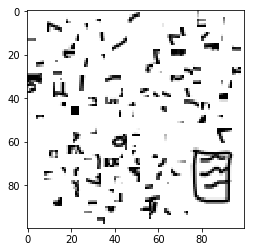

In [4]:
tmpImg = images[952][1].reshape((100,100)).astype(np.uint8)
plt.imshow(tmpImg, cmap='gray_r')
plt.show()

In [5]:
# Try to find contours
from skimage import measure
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


def getLongestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=lambda x: len(x), reverse=True)
    return img_contours[0]

# need to wrap with try / except, for when contour is invalid 
def tryPolygonArea(contour):
    try:
        return Polygon(contour).area
    except:
        return 0

def getLargestContour(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    img_contours.sort(key=tryPolygonArea, reverse=True)
    return img_contours[0]
    

def overlayContour(img, contour):
    plt.imshow(img, cmap='gray_r')
    # Plot the longest contour
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    plt.show()

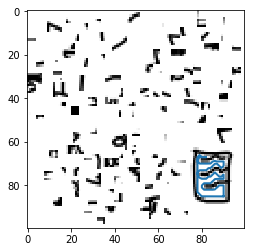

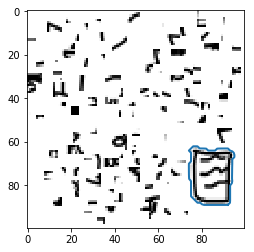

In [6]:
tmpImg = images[952][1].reshape((100,100)).astype(np.uint8)

longest_contour = getLongestContour(tmpImg)
overlayContour(tmpImg, longest_contour)
largest_contour = getLargestContour(tmpImg)
overlayContour(tmpImg, largest_contour)

# Using contours to find noise

There are two methods to find an image in noise. The first is by looking at the contour length. The second is by looking at the contour area. We can see that there often is only one or two contours with significantly greater size:

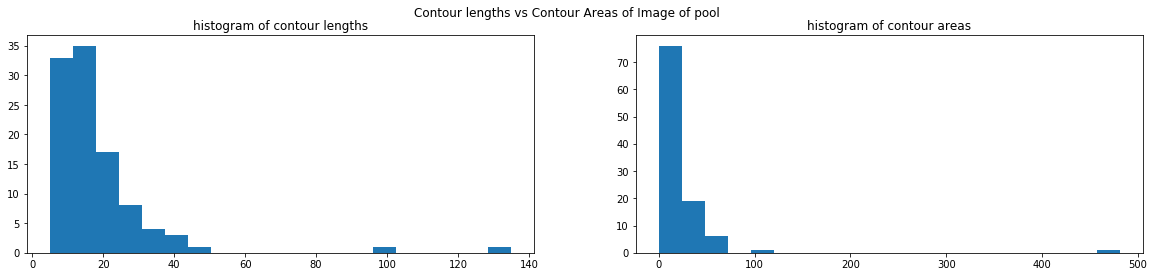

In [7]:
# histogram of contours to find potentially noise

def plotContourLengths(contours, show = True):
    contour_lengths = np.zeros(len(contours))
    for i, contour in enumerate(contours):
        contour_lengths[i] += float(len(contour))
    if show:
        plt.hist(contour_lengths, bins=20)
        plt.title('histogram of contour lengths')
        plt.show()

    return contour_lengths

def plotContourAreas(contours, show = True):
    contour_areas = np.zeros(len(contours))
    for i, contour in enumerate(contours):
        try:
            contour_areas[i] += float(Polygon(contour).area)
        except:
            contour_areas[i] += 0
    if show:
        plt.hist(contour_areas, bins=20)
        plt.title('histogram of contour areas')
        plt.show()
    return contour_areas

def plotBoth(contour_lengths, contour_areas, title = ''):
    f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
    axarr[0].hist(contour_lengths, bins=20)
    axarr[0].set_title('histogram of contour lengths')
    axarr[1].hist(contour_areas, bins=20)
    axarr[1].set_title('histogram of contour areas')
    f.suptitle(title)
    plt.show()

def findAndPlotContourLengths(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    plotContourLengths(img_contours)
    
def findAndPlotContourAreas(img):
    img_contours = measure.find_contours(img, 0.99, 'high')
    plotContourAreas(img_contours)

tmpImg_contours = measure.find_contours(tmpImg, 0.99, 'high')
plotBoth(plotContourLengths(tmpImg_contours, False), plotContourAreas(tmpImg_contours, False),'Contour lengths vs Contour Areas of Image of pool')

# Trends of Contours in Noise-only (empty) images versus Non-noise-only (not empty) images

We can detect noise-only images by looking at the size of either of these metrics:

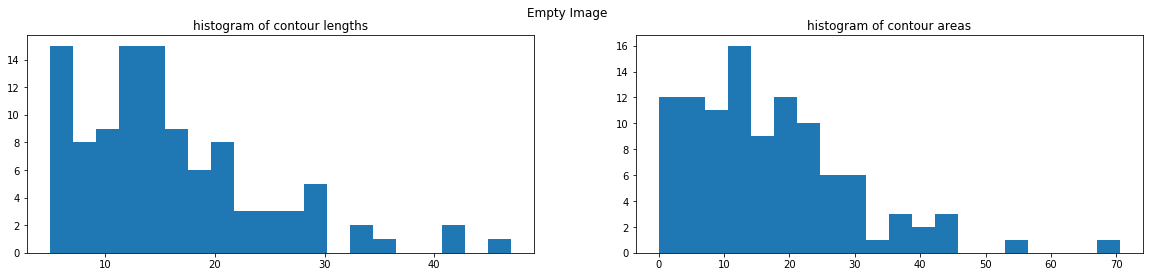

In [8]:
empty_img = images[97][1].reshape((100,100)).astype(np.uint8)
empty_img_contours = measure.find_contours(empty_img, 0.99, 'high')
plotBoth(plotContourLengths(empty_img_contours, False), plotContourAreas(empty_img_contours, False),'Empty Image')


### Histogram of area and length of largest contours in all noise-only images in test set

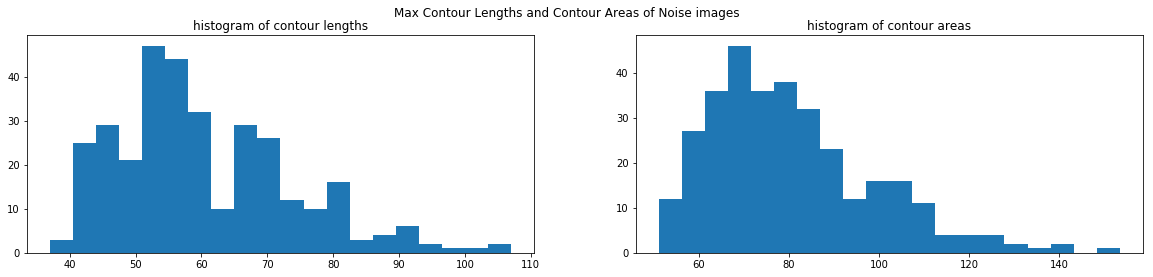

In [9]:
noise_only_images = labels[labels['Category'].isin({'empty'})]
NoiseLongestContours = []
NoiseLargestContours = []

for ID in noise_only_images['Id']:
    noiseImg = images[ID][1].reshape((100,100)).astype(np.uint8)
    NoiseLongestContours.append(getLongestContour(noiseImg))
    NoiseLargestContours.append(getLargestContour(noiseImg))

plotBoth(plotContourLengths(NoiseLongestContours, False), plotContourAreas(NoiseLargestContours, False), 'Max Contour Lengths and Contour Areas of Noise images')


### Histogram of area and length of *non-noise* images in test-set

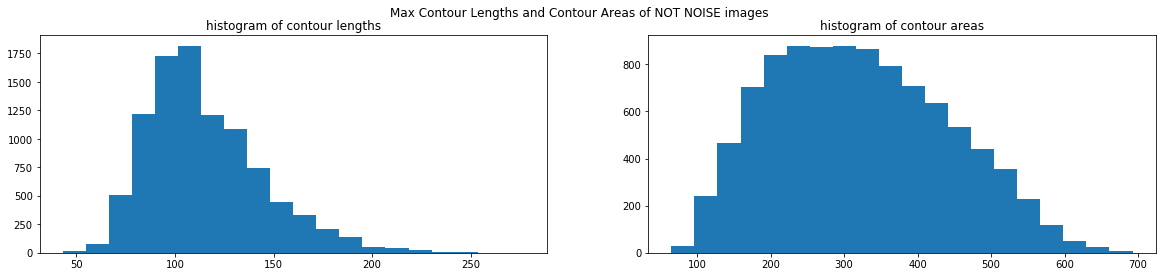

In [10]:
not_noise_images = labels[~labels['Category'].isin({'empty'})]
notNoiseLongestContours = []
notNoiseLargestContours = []
for ID in not_noise_images['Id']:
    notNoiseImg = images[ID][1].reshape((100,100)).astype(np.uint8)
    notNoiseLongestContours.append(getLongestContour(notNoiseImg))
    notNoiseLargestContours.append(getLargestContour(notNoiseImg))

plotBoth(plotContourLengths(notNoiseLongestContours, False), plotContourAreas(notNoiseLargestContours, False), 'Max Contour Lengths and Contour Areas of NOT NOISE images')


## Conclusions from the above data

The majority of the largest contour areas for noise-only images lie between 60 and 100, whereas the majority of the largest contour areas for non-noise images are larger than 100. This means that it is relatively safe to assume that the largest contour is of the drawing, and not of some other noise.

# A potential route: use Naive Filter to remove noise

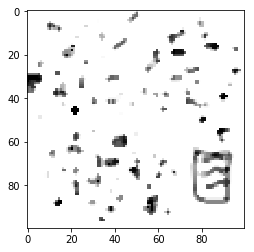

In [11]:
# Use some sort of naive filter (deprecated)
from skimage.filters.rank import median
from skimage.morphology import disk

med_filter_tmpImg = median(tmpImg, disk(1.9))

plt.imshow(med_filter_tmpImg, cmap='gray_r')

plt.show()

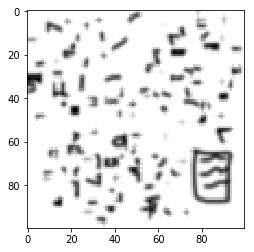

In [12]:
from skimage.filters.rank import mean
med_filter_tmpImg = mean(tmpImg, disk(1))

plt.imshow(med_filter_tmpImg, cmap='gray_r')

plt.show()

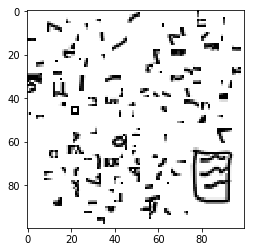

In [13]:
from skimage.filters.rank import autolevel
med_filter_tmpImg = autolevel(tmpImg.astype(np.uint16), disk(1))
plt.imshow(med_filter_tmpImg, cmap='gray_r')

plt.show()

# Remove noise via Raycast on contour

There are two ways we can select which contour to use:

1. The contour that is longest (largest surface area)
2. The contour that has the largest area

The function below allows for either case. Either put down `contour_type='longest'` for (1), or `contour_type=largest` for (2)

In [14]:
def removeNoiseViaContour(oldImg, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    polygon = Polygon(contour)
    #set to 0
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
    #iterate through old image
    for i in range(len(oldImg)):
        for j in range(len(oldImg[i])):
            point = Point(i,j)
            if polygon.contains(point):
                newImg[i][j] = oldImg[i][j]
    return newImg

## How to choose which method?

It seems like the second method is better than the first. This is because the longest contour may in fact be inside of the image, and so none of the lines of the image are actually inside of the first polygon. In the other case, however, we choose the contour with the largest area, which will most likely also surround the image. See the example below for the potential issue with choice (1):

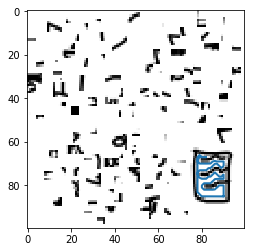

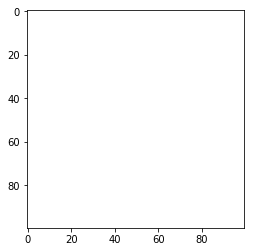

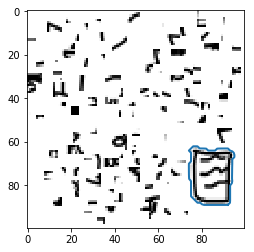

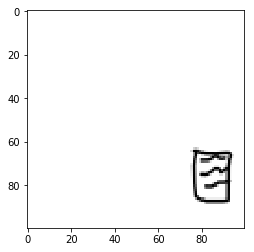

In [15]:
not_noise_img = removeNoiseViaContour(tmpImg)
longest_contour = getLongestContour(tmpImg)
overlayContour(tmpImg, longest_contour)
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

largest_contout = getLargestContour(tmpImg)
overlayContour(tmpImg, largest_contout)
not_noise_img = removeNoiseViaContour(tmpImg, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

# Remove noise by Raycasting on the bounding box of the contour

This method guarantees that the lines of the image that stay are also inside of the contour. However, this method may also not remove a lot of the noise in the thinner drawings.

In [16]:
# Get the bounding box of the contour
def boundingBoxOfContour(contour):
    minX = float("inf")
    minY = float("inf")
    maxX = -1
    maxY = -1
    for x,y in contour:
        if minX > x:
            minX = x
        if minY > y:
            minY = y
        if maxX < x:
            maxX = x
        if maxY < y:
            maxY = y
    return minX, minY, maxX,maxY

# Removes noise based off of the bounding box of the longest contour. Buffer is how much additional 
# space we want to provide beyond the bounding box.
# If buffer < 1, it will add buffer equal to the (largest side of bounding box * buffer)
def removeNoiseViaBoundingBox(oldImg, buffer = 0, contour_type='longest'):
    if contour_type == 'longest':
        contour = getLongestContour(oldImg)
    elif contour_type == 'largest':
        contour = getLargestContour(oldImg)
    else:
        print("Invalid contour_type:", contour_type, ". Allowed values: longest, largest")
        raise
    minX, minY, maxX, maxY = boundingBoxOfContour(contour)
    
    if (buffer < 1):
        maxLength = max(maxX - minX, maxY - minY)
        buffer = buffer * maxLength
    # overlayContour(oldImg, np.array([[minX, minY], [minX, maxY], [maxX, maxY], [minX, maxY], [minX, minY]]))
    
    newImg = [[0 for j in range(len(oldImg[i]))] for i in range(len(oldImg))]
        
    #iterate through old image
    for x in range(len(oldImg)):
        for y in range(len(oldImg[x])):
            if x >= (minX - buffer) and x <= (maxX + buffer) and y >= (minY - buffer) and y <= (maxY + buffer):
                newImg[x][y] = oldImg[x][y]
    return newImg

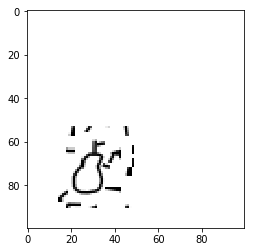

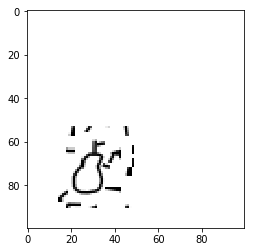

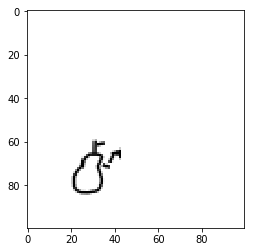

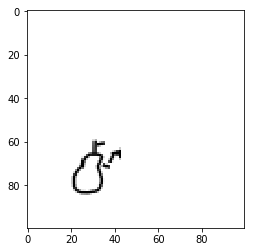

In [17]:
tmpImg = images[78][1].reshape((100,100)).astype(np.uint8)

not_noise_img = removeNoiseViaBoundingBox(tmpImg, .2, 'longest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaBoundingBox(tmpImg, .2, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaContour(tmpImg, 'longest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

not_noise_img = removeNoiseViaContour(tmpImg, 'largest')
plt.imshow(not_noise_img, cmap='gray_r')
plt.show()

# center, crop, and rescale an image

In [68]:
from scipy.ndimage import zoom

#Finds the first non-zero coordinate, and the last non-zero coordinate.
def boundingBox(img):
    minX = -1
    minY = -1
    maxX = -1
    maxY = -1
    for i, row in enumerate(img):
        nonZeroIndexes = np.nonzero(row)[0]
        if len(nonZeroIndexes) != 0:
            if minX == -1:
                minX = i
            if minY == -1 or minY > np.min(nonZeroIndexes):
                minY = np.min(nonZeroIndexes)
            if maxX < i:
                maxX = i
            if maxY < np.max(nonZeroIndexes):
                maxY = np.max(nonZeroIndexes)
    return (minX, minY), (maxX,maxY)

# Centers the image
def center(img):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0]
    yLength = maxCoord[1] - minCoord[1]
    newImg = [[0 for j in range(len(img[i]))] for i in range(len(img))]
    
    startX = int((len(img) - xLength) / 2)
    startY = int((len(img[0]) - yLength) / 2)
    for i,x in enumerate(range(startX, startX + xLength + 1)):
        for j,y in enumerate(range(startY, startY + yLength + 1)):
            newImg[x][y] = img[minCoord[0]+i][minCoord[1]+j]
    return newImg

# Crop out all of the white space. If you want square dimensions, then it will pad white space.
def cropWhite(img, isSquare = False, whiteBoundary = True):
    minCoord, maxCoord = boundingBox(img)
    xLength = maxCoord[0] - minCoord[0] + 3
    yLength = maxCoord[1] - minCoord[1] + 3
    if isSquare:
        xLength = max(xLength, yLength)
        yLength = max(xLength, yLength)
    
    newImg = [[0 for j in range(yLength + 1)] for i in range(xLength + 1)]
    for i in range(xLength):
        for j in range(yLength):
            # Check for case where we are out of bounds for cropped white + square
            if (minCoord[0] + i) >= len(img) or (minCoord[1] + j) >= len(img[i]):
                newImg[i + 1][j + 1] = 0
            else:
                newImg[i + 1][j + 1] = img[minCoord[0] + i][minCoord[1] + j]
    return newImg

# rescale image to square of height, width = dimension    
def rescale(img, dimension, order = 0):
    cropped = cropWhite(img)
    height = len(cropped)
    width = len(cropped[0])
    zoomFactor = dimension / max(height, width)
    return zoom(img, zoomFactor, order=order)

def sharpen(img, cutoff = 110):
    newImg = []
    for row in img:
        newRow = []
        for pixel in row:
            if pixel < cutoff:
                newRow.append(0)
            else:
                newRow.append(255)
        newImg.append(newRow)
    return np.asarray(newImg)

### Centered image

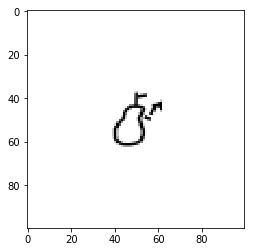

In [69]:
centered_img = center(not_noise_img)
plt.imshow(centered_img, cmap='gray_r')
plt.show()

### Cropped image, without whitespace

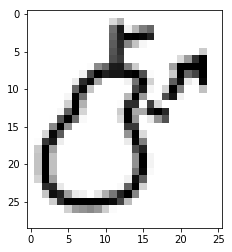

In [70]:
cropped = cropWhite(not_noise_img, False)
plt.imshow(cropped, cmap='gray_r')
plt.show()

### Add whitespace so that the image has square dimensions

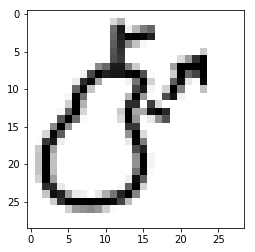

In [84]:
cropped_white = cropWhite(not_noise_img, True)
plt.imshow(cropped_white, cmap='gray_r')
plt.show()

### Rescale the image so that the larger side is 40px

(40, 40)


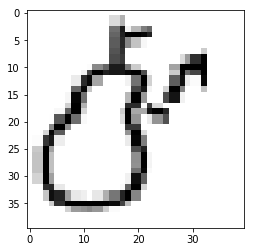

In [85]:
rescaled = rescale(cropped_white, 40, 0)
print(rescaled.shape)
plt.imshow(rescaled, cmap='gray_r')
plt.show()

### Map light pixels to 255, and darker pixels to 0

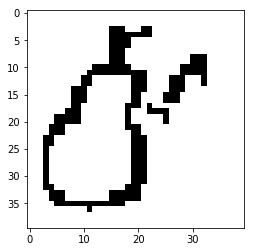

In [86]:
sharpenedImg = sharpen(rescaled, 110)
plt.imshow(sharpenedImg, cmap='gray_r')
plt.show()

# Preprocess an image

### Steps:
1. Filter image either by racasting via `bounding_box` or via `contour_only`. Choose which contour to do bounding-box / raycasting on by stating either contour_type = `longest` or `largest`.
2. Crop image sot that we remove excess whitespace. Make image square.
3. Center image.
4. Rescale image to the `rescaleDimension`
5. Apply a spline interpolation factor of order `order`

In [108]:
def preprocessImg(img, noiseRemoveType='contour_only', contour_type='largest', rescaleDimension = 40, order = 1, sharpen = False, reFilter = False):
    if noiseRemoveType == 'bounding_box':
        filteredImg = removeNoiseViaBoundingBox(img, .2, contour_type)
    elif noiseRemoveType == 'contour_only':
        filteredImg = removeNoiseViaContour(img, contour_type)
    else:
        print("Invalid noiseRemoveType:", noiseRemoveType, ". Allowed values: bounding_box, contour_only")
        raise 
    croppedImg = cropWhite(filteredImg, True)
    centered_img = center(croppedImg)
    rescaled_img = rescale(centered_img, rescaleDimension, order)
    if sharpen:
        sharpened_img = sharpen(rescaled_img, 110)
        if reFilter:
            return removeNoiseViaContour(sharpened_img, contour_type)
        return sharpened_img
    else:
        if reFilter:
            return removeNoiseViaContour(rescaled_img, contour_type)
        return rescaled_img

### Test which combination of noiseType and contour work best for a given image.

In [107]:
def testTypesOfPreprocessing(img):
    processedImgs = []
    for noiseType in ['bounding_box', 'contour_only']:
        for contour in ['longest', 'largest']:
            for order in range(0,3):
                for sharpen in [True, False]:
                    processed = preprocessImg(img, noiseRemoveType=noiseType, contour_type=contour, order=order, sharpen=sharpen)
                    processedImgs.append({
                        'noiseType':noiseType,
                        'contour':contour,
                        'order':order,
                        'bounded': bounded,
                        'img':processed
                    })
    return processedImgs


# Call this function to run and then display the test results. Include a directory in "saveDirectory" if you want to save the plot.
def displayPreprocessingTestResults(img, title, saveDirectory=None):
    results = testTypesOfPreprocessing(img)
    numCols = 8
    numRows = int(len(results) / numCols)
    f, axarr = plt.subplots(nrows=numCols, ncols=numRows, figsize=(20, 40))
    f.suptitle(title)
#     axarr[0][0].imshow(img, cmap='gray_r')
#     axarr[0][0].set_title('original')

    curCol = 0
    curRow = 0
    for i,result in enumerate(results):
        axarr[curCol][curRow].imshow(result['img'], cmap='gray_r')
        sub_title = str.format('noiseType: %s, contour: %s, \n order: %d, bounded: %s'% ( 
                                    result['noiseType'],
                                    result['contour'],
                                    result['order'],
                                    result['bounded'])
                              )
        axarr[curCol][curRow].set_title(sub_title)
        if curRow == numRows - 1:
            curRow = 0
            curCol += 1
        else:
            curRow += 1
    plt.show()
    if saveDirectory is not None:
        plt.savefig(saveDirectory + '/' + title + '.png')


#### Example usage of the above function:

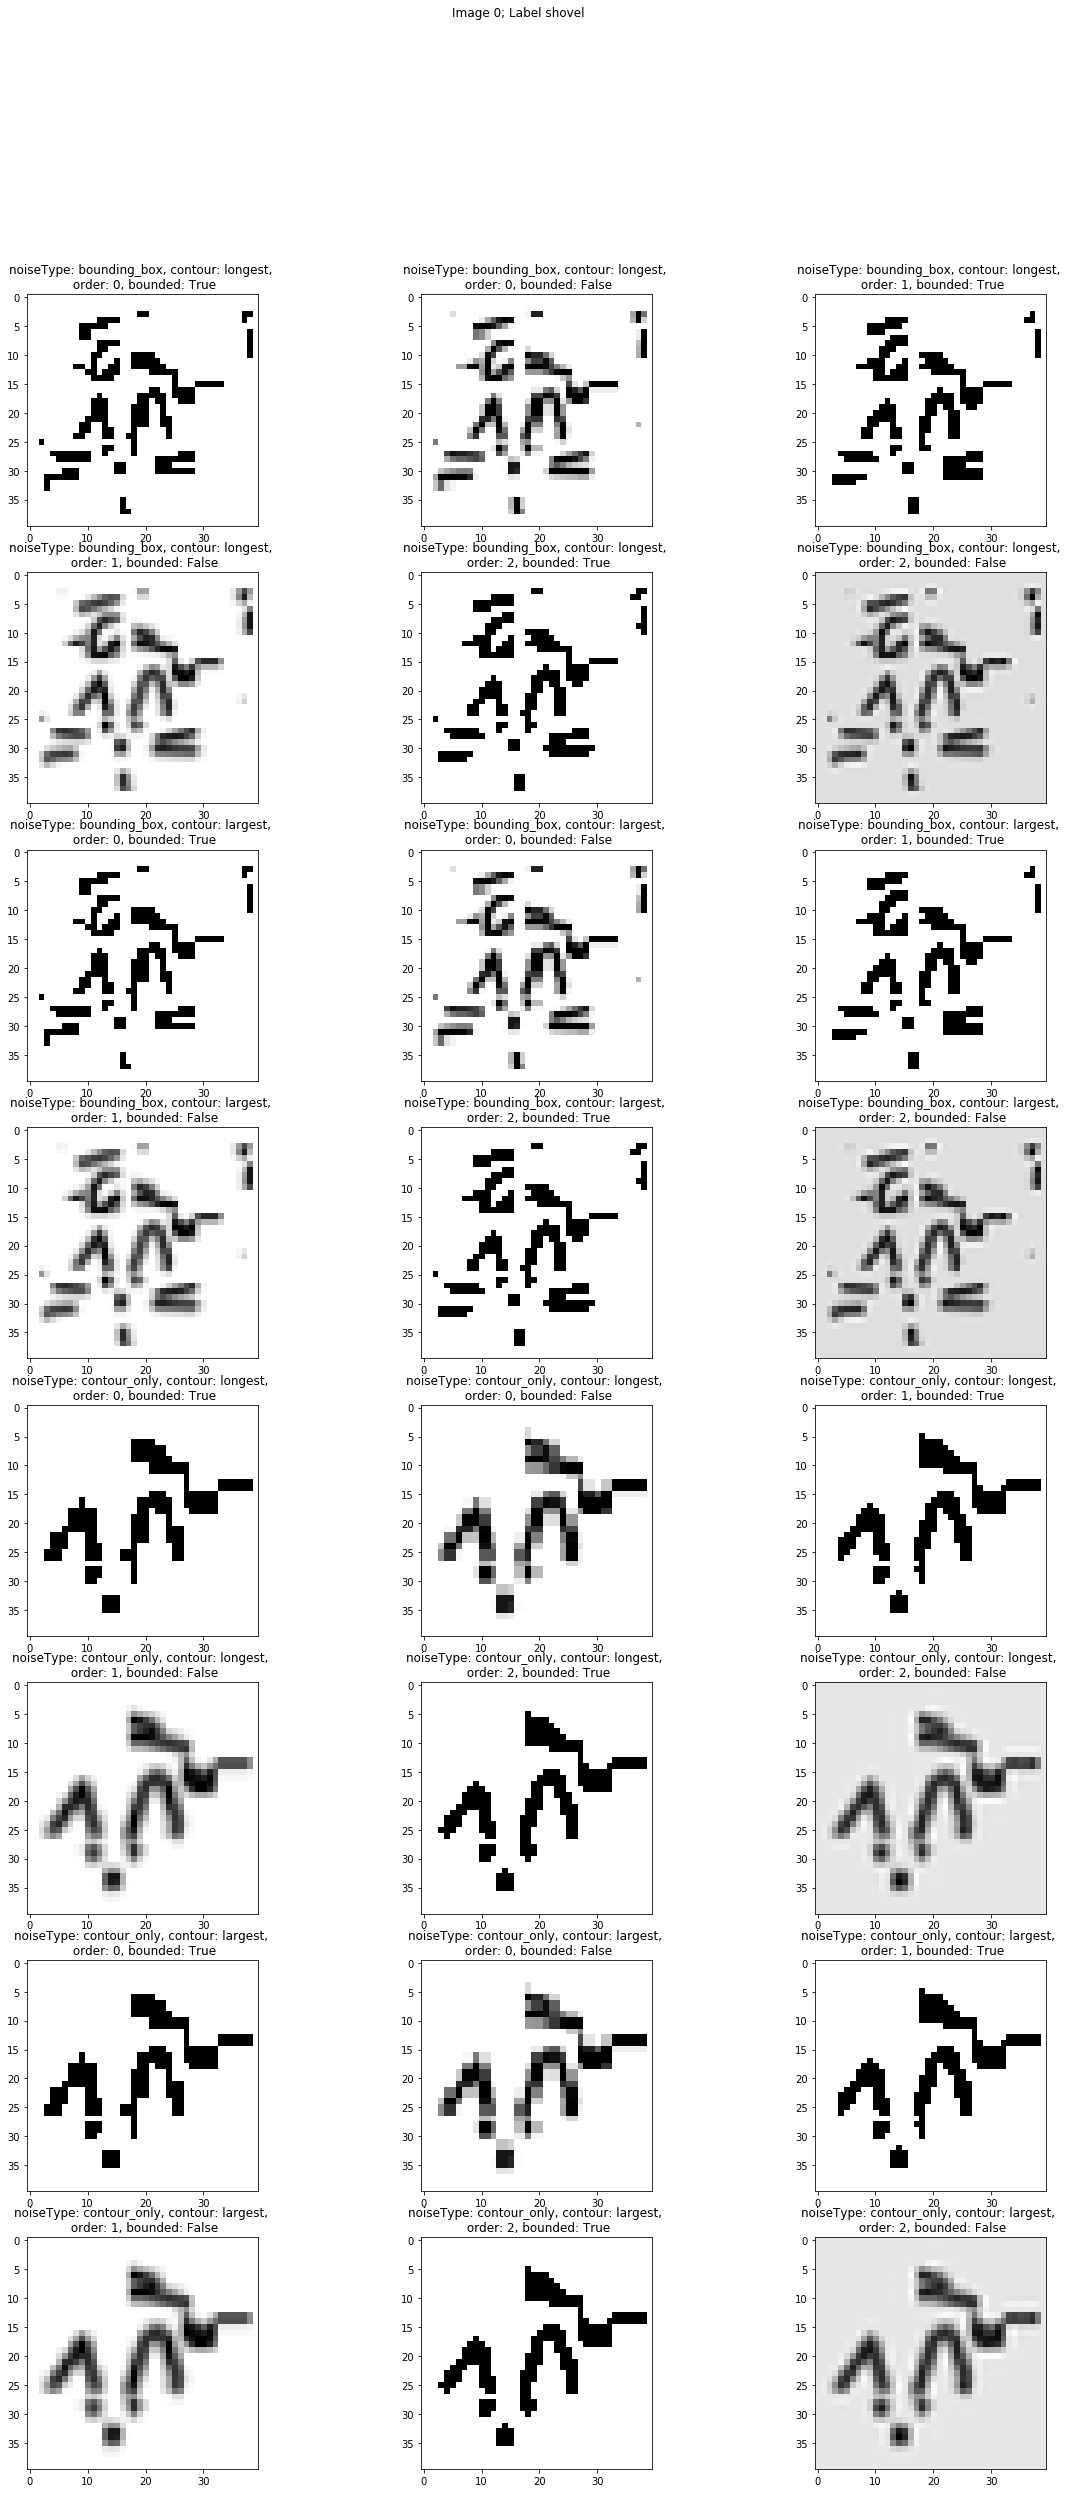

In [97]:
img_0 = images[5000][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_0, 'Image 0; Label '+labels.at[0,'Category'])

# Run through range of images and compare

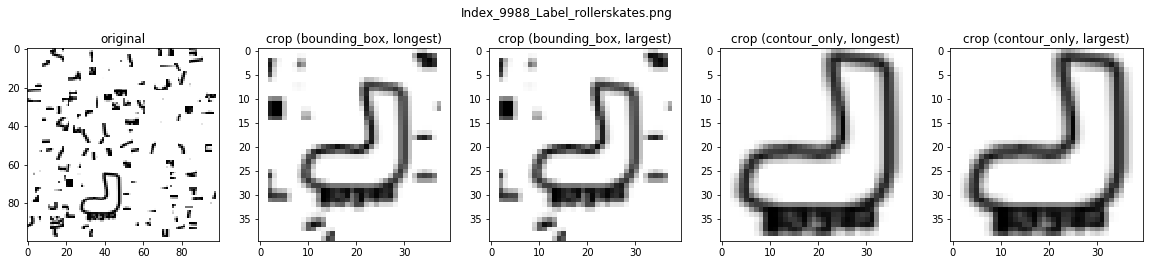

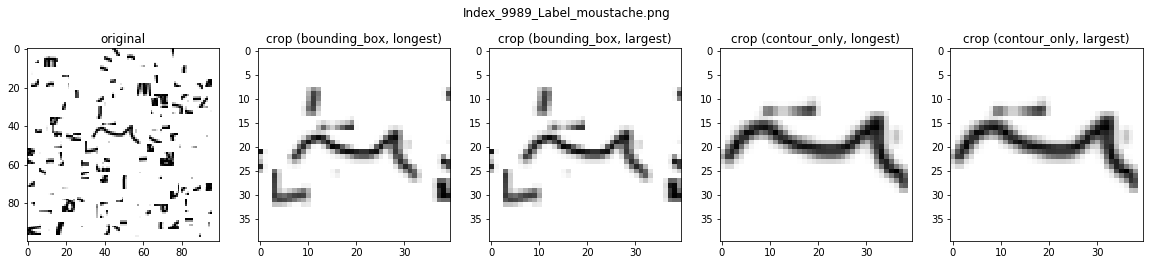

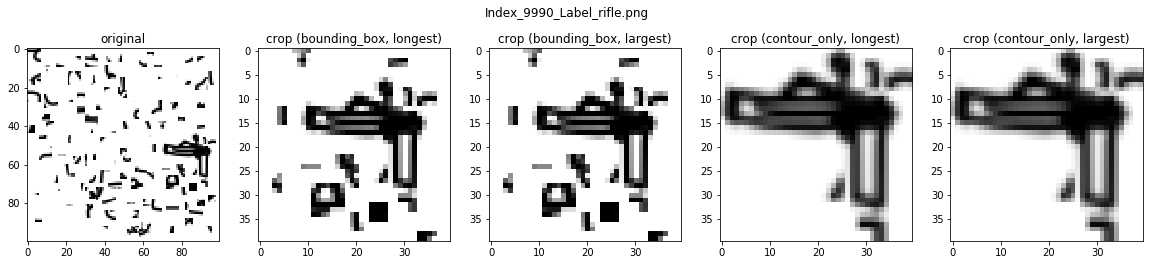

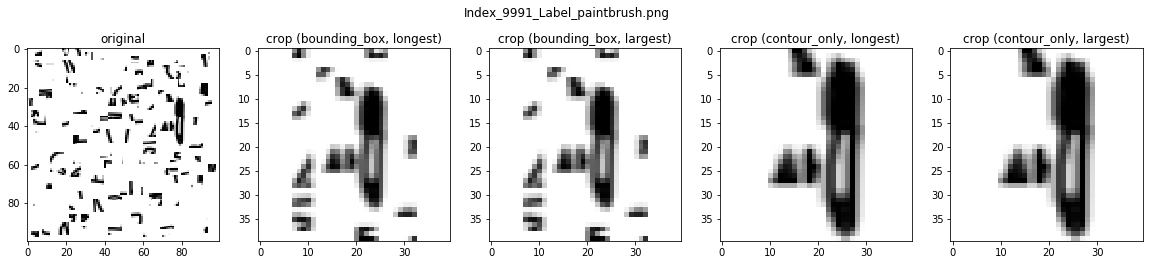

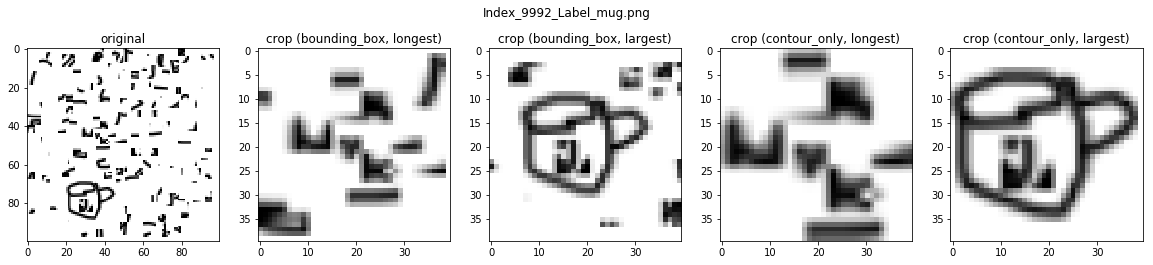

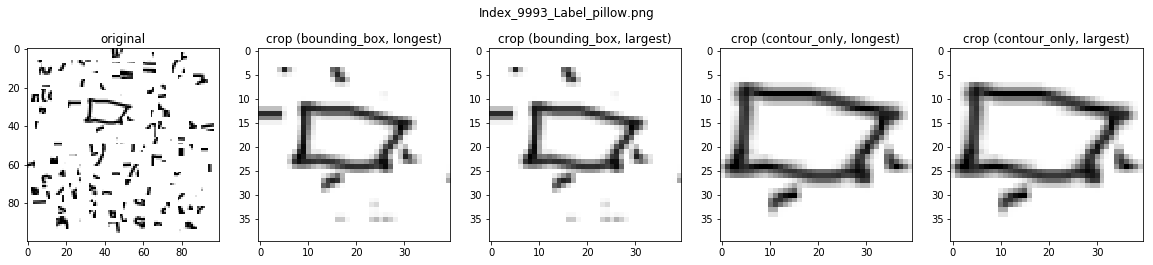

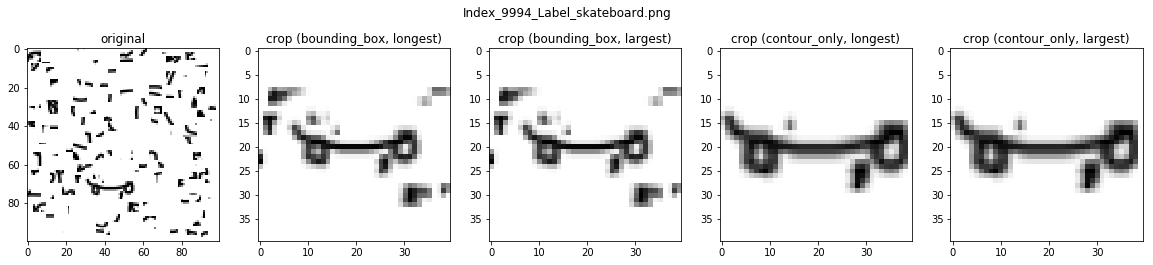

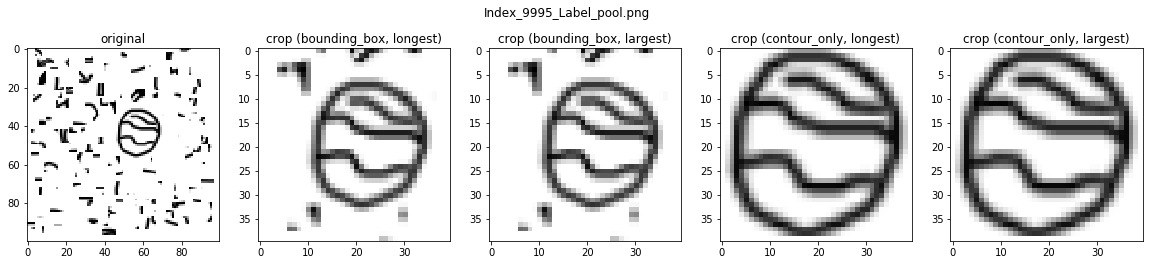

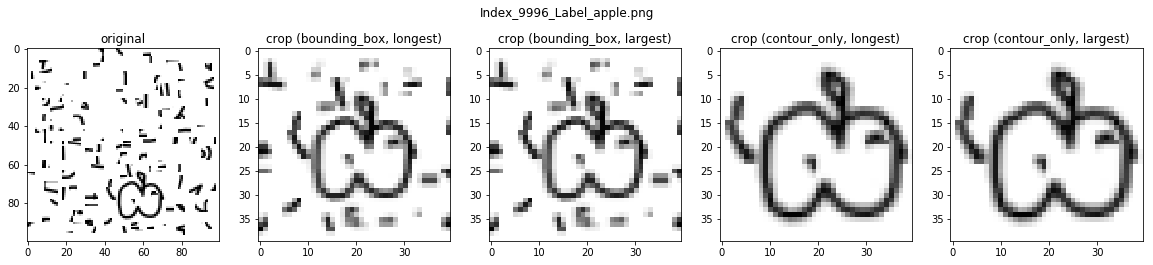

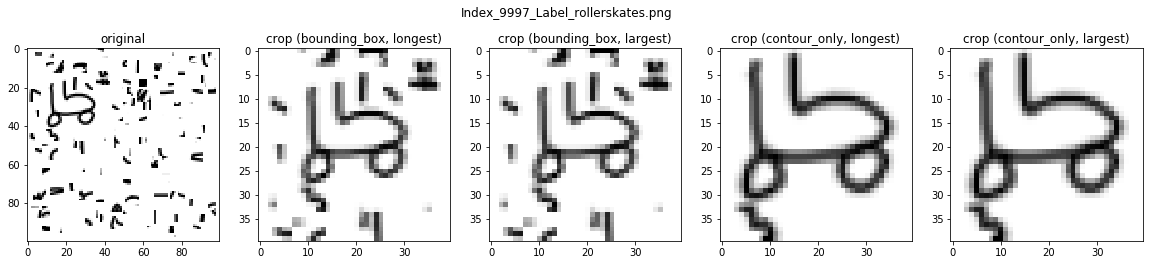

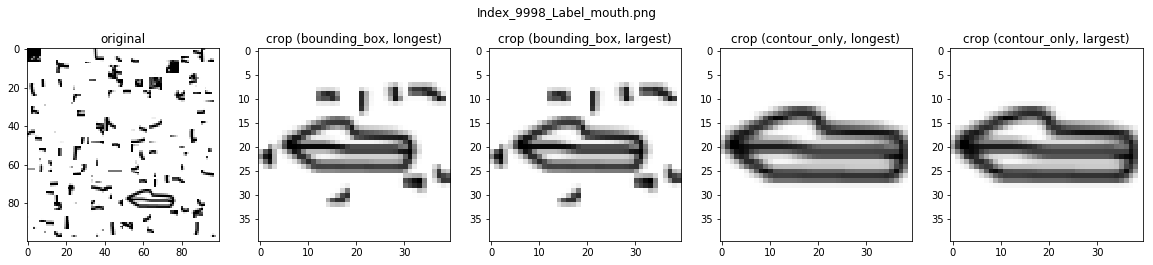

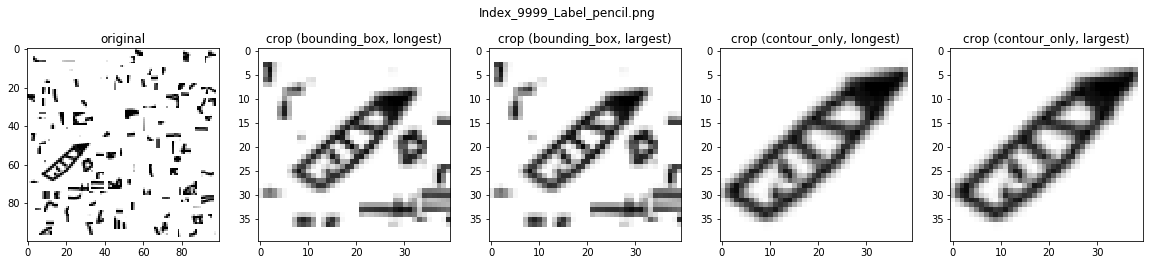

In [107]:
startI = 9988
endI = 10000
for i in range(startI, endI):
    img = images[i][1].reshape((100,100)).astype(np.uint8)
    title = "Index_" + str(i) + "_Label_" + labels.at[i,'Category'] + '.png'
    #directory = "img/"+str(startI)+"-"+str(endI - 1)
    #displayPreprocessingTestResults(img, title, directory)
    displayPreprocessingTestResults(img, title)


# Conclusions about preprocessing

It seems like the combination of doing raycasting on the contour with the largest area gives us the best results for removing noise while also keeping the image, however some failure cases are images 892, and 1133:


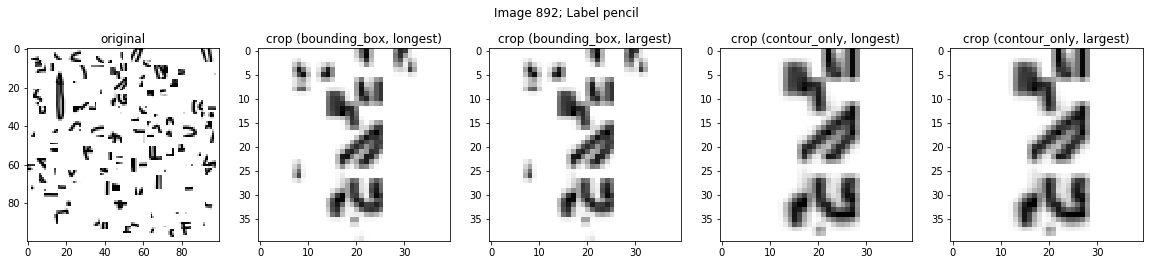

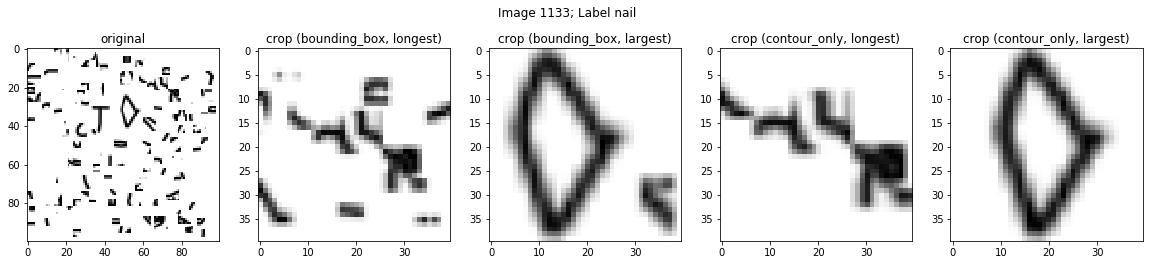

In [51]:
img_892 = images[892][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_892, 'Image 892; Label '+labels.at[892,'Category'])
img_1133 = images[1133][1].reshape((100,100)).astype(np.uint8)
displayPreprocessingTestResults(img_1133, 'Image 1133; Label '+labels.at[1133,'Category'])

# Save processed images

In [27]:
# Assumes image
def save(outfile, images):
    reformattedImgs = []
    for i, image in enumerate(images):
        reformattedImg = image.reshape((1,image.shape[0] * image.shape[1]))
        reformattedImgs.append(reformattedImg)
    nparr = np.asarray(reformattedImgs)
    np.save(outfile, nparr)

In [103]:
def preprocessImages(outfile, images, noiseRemoveType='contour_only', contour_type='largest', rescaleDimension = 40, sharpen=False):
    preprocessedImgs = []
    for img in images:
        formatted = img[1].reshape((100,100)).astype(np.uint8)
        processedImg = preprocessImg(formatted, noiseRemoveType='contour_only', contour_type='largest', rescaleDimension=rescaleDimension, sharpen=sharpen)
        preprocessedImgs.append(processedImg)
    save(outfile, preprocessedImgs)

In [36]:
preprocessImages('./data/preprocessed_interpolated_bounded', images) 

In [49]:
preprocessImages('./data/preprocessed_interpolated_28_28', images, rescaleDimension=28, sharpen=False)

# Load preprocessed images

In [434]:
def load(infile):
    unformatted_images = np.load(infile, encoding='bytes')
    formatted = []
    for i,img in enumerate(unformatted_images):
        formatted.append([i, img[0]])
    return formatted

# Noise-Or-Not-Noise (NoNN) Classifier

## Features we might want to sample from

We believe that from the contours, we can determine whether or not an image is empty. We are going to investigate which of the following features has the most separation between the two classes.

In [399]:
def generateNoiseFeatures(image):
    formatted = image[1].reshape((100,100)).astype(np.uint8)
    img_contours = measure.find_contours(formatted, 0.99, 'high')
    areas = list(map(tryPolygonArea, img_contours))
    lengths = list(map(lambda x: len(x), img_contours))
    
    num_contours = len(img_contours)
    
    area_mean = np.mean(areas)
    area_std = np.std(areas)
    area_max = max(areas)
    
    length_mean = np.mean(lengths)
    length_std = np.std(lengths)
    length_max = max(lengths)

    return np.asarray([num_contours, area_mean, area_std, area_max, length_mean, length_std, length_max])

def formatDataEmptyOrNotEmpty(images, labels):
    X = []
    y = []

    for i, img in enumerate(images):
        label = labels.at[i,'Category']
        isNoise = 1 if label == 'empty' else 0
        X.append(generateNoiseFeatures(img))
        y.append(isNoise)
    return X,y

def makeHistogram(data):
    # Generate the histogram data directly
    hist, bin_edges = np.histogram(data, bins=20)
    hist = list(map(lambda x: x / len(data), hist))
    # Get the cin centres rather than the edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    return bin_centers,hist

def plotPDFFeature(X, y, featureNumber, title = ''):
    plotNoise = []
    plotNotNoise = []
    for i, xVal in enumerate(X):
        if y[i] == 0:
            plotNotNoise.append(xVal[featureNumber])
        else:
            plotNoise.append(xVal[featureNumber])        
    bc_1, hnc_1 = makeHistogram(plotNoise)
    bc_2, hnc_2 = makeHistogram(plotNotNoise)
    
    # Plot
    plt.plot(bc_1, hnc_1, alpha=0.5, label='empty')
    plt.plot(bc_2, hnc_2, alpha=0.5, label='not empty')
    plt.title(title)
    plt.legend(loc='upper right')

    plt.show()


In [396]:
X,y = formatDataEmptyOrNotEmpty(images, labels)

### Here are the relative PDFs of the following features generated from contours:

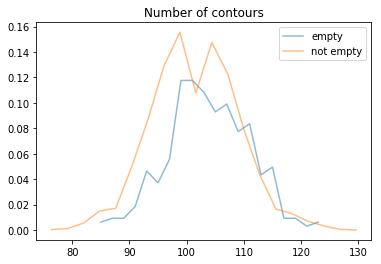

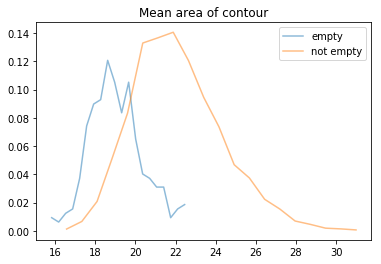

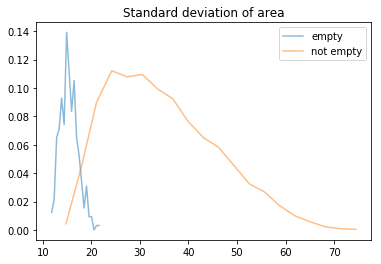

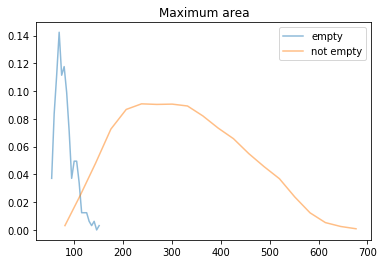

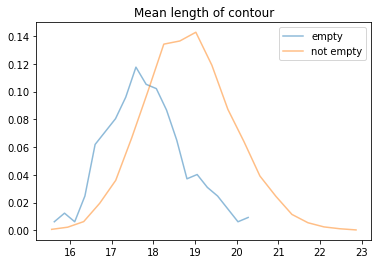

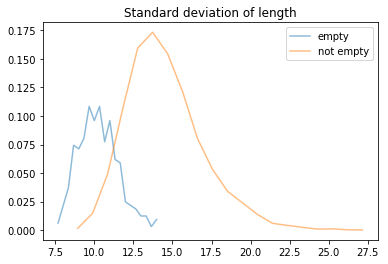

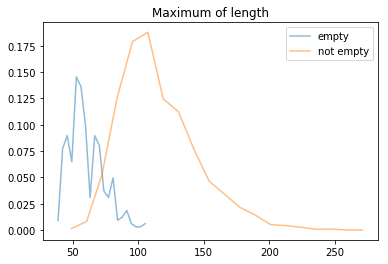

In [401]:
plotPDFFeature(X, y, 0, "Number of contours")
plotPDFFeature(X, y, 1, "Mean area of contour")
plotPDFFeature(X, y, 2, "Standard deviation of area")
plotPDFFeature(X, y, 3, "Maximum area")
plotPDFFeature(X, y, 4, "Mean length of contour")
plotPDFFeature(X, y, 5, "Standard deviation of length")
plotPDFFeature(X, y, 6, "Maximum of length")

## Training NoNN on these features

In [456]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
    
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) 
    return X_train, y_train, X_test, y_test, X_val, y_val

def test(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    #print(confusion_matrix(y_test, y_pred))
    average = 'micro' if len(set(y_test)) > 2 else 'binary'
    return f1_score(y_test, y_pred, average=average), accuracy_score(y_test, y_pred)

In [378]:
X_train, y_train, X_test, y_test, X_val, y_val = split(X, y)

bestF1 = 0
bestK = 0
for k in range(1,1000):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    f1, accuracy = test(classifier, X_test, y_test)
    bestK = k if bestF1 < f1 else bestK
    bestF1 = f1 if bestF1 < f1 else bestF1
bestF1, bestK

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.848, 6)

In [384]:
errorOrNotClassifier = KNeighborsClassifier(n_neighbors=6).fit(X_train, y_train)
test(errorOrNotClassifier, X_val, y_val)

0.8518518518518519

# Training on all of the pre-processed data

### Helper methods to format data

In [475]:
from sklearn.naive_bayes import MultinomialNB
CATEGORIES = ['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose', 'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear', 'pencil', 'penguin', 'pillow', 'pineapple', 'pool', 'rabbit', 'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion', 'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon', 'squiggle']

def getIndexOf(category):
    return CATEGORIES.index(category)

def getCategoryOf(index):
    return CATEGORIES[index]

def formatData(images, labels):
    categories = list(set(labels['Category']))
    X = []
    y = []
    for i, img in enumerate(images):
        label = labels.at[i,'Category']
        categoryNum = getIndexOf(label)
        X.append(img[1])
        y.append(categoryNum)
    return X,y

In [206]:
XAll, yAll = formatData(load('./data/processedData.npy'), labels)

NameError: name 'formatData' is not defined

In [436]:
X_train, y_train, X_test, y_test, X_val, y_val = split(XAll, yAll)

## Multinomial NB Classifier

In [437]:
bestF1 = 0
bestAlpha = 0
for alpha in range(1,100):
    classifier = MultinomialNB(alpha=alpha)
    classifier.fit(X_train, y_train)
    f1, accuracy = test(classifier, X_test, y_test)
    bestAlpha = alpha if bestF1 < f1 else bestAlpha
    bestF1 = f1 if bestF1 < f1 else bestF1
bestF1, bestAlpha

(0.3525, 98)

In [449]:
classifier = MultinomialNB(alpha=98)
classifier.fit(X_train, y_train)
test(classifier, X_val, y_val)

0.31875

## K nearest neighbors

In [444]:
bestF1 = 0.4175
bestK = 6 # tested ranges 1-6 already, with best results being at 6
for k in range(7,10):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    f1, accuracy = test(classifier, X_test, y_test)
    print('f1 score',f1,'; k',k)
    bestK = k if bestF1 < f1 else bestK
    bestF1 = f1 if bestF1 < f1 else bestF1
bestF1, bestK

f1 score 0.4125 ; k 7
f1 score 0.409 ; k 8
f1 score 0.4075 ; k 9


(0.4175, 6)

In [446]:
classifier = KNeighborsClassifier(n_neighbors=6)
classifier.fit(X_train, y_train)
test(classifier, X_val, y_val)

0.39625

## Random Forest

In [455]:
from sklearn.ensemble import RandomForestClassifier

bestF1 = 0.3425
bestNEstimators = 14
bestCriterion = 'entropy'
for n_estimator in range(15,100):
    for criterion in ['gini','entropy']:
        classifier = RandomForestClassifier(n_estimators=n_estimator, criterion=criterion)
        classifier.fit(X_train, y_train)
        f1, accuracy = test(classifier, X_test, y_test)
        print('f1 score',f1,'; n_estimators',n_estimator,'; criterion',criterion)
        bestNEstimators = n_estimator if bestF1 < f1 else bestNEstimators
        bestCriterion = criterion if bestF1 < f1 else bestCriterion
        bestF1 = f1 if bestF1 < f1 else bestF1
bestF1, bestNEstimators, bestCriterion

f1 score 0.3285 ; n_estimators 15 ; criterion gini
f1 score 0.343 ; n_estimators 15 ; criterion entropy
f1 score 0.3515 ; n_estimators 16 ; criterion gini
f1 score 0.3415 ; n_estimators 16 ; criterion entropy
f1 score 0.357 ; n_estimators 17 ; criterion gini
f1 score 0.3575 ; n_estimators 17 ; criterion entropy
f1 score 0.3725 ; n_estimators 18 ; criterion gini
f1 score 0.357 ; n_estimators 18 ; criterion entropy
f1 score 0.361 ; n_estimators 19 ; criterion gini
f1 score 0.3665 ; n_estimators 19 ; criterion entropy
f1 score 0.3695 ; n_estimators 20 ; criterion gini
f1 score 0.36499999999999994 ; n_estimators 20 ; criterion entropy
f1 score 0.367 ; n_estimators 21 ; criterion gini
f1 score 0.369 ; n_estimators 21 ; criterion entropy
f1 score 0.3765 ; n_estimators 22 ; criterion gini
f1 score 0.376 ; n_estimators 22 ; criterion entropy
f1 score 0.378 ; n_estimators 23 ; criterion gini
f1 score 0.373 ; n_estimators 23 ; criterion entropy
f1 score 0.3815 ; n_estimators 24 ; criterion gini


f1 score 0.4425 ; n_estimators 92 ; criterion gini
f1 score 0.4405 ; n_estimators 92 ; criterion entropy
f1 score 0.4395 ; n_estimators 93 ; criterion gini
f1 score 0.4445 ; n_estimators 93 ; criterion entropy
f1 score 0.434 ; n_estimators 94 ; criterion gini
f1 score 0.454 ; n_estimators 94 ; criterion entropy
f1 score 0.4355 ; n_estimators 95 ; criterion gini
f1 score 0.451 ; n_estimators 95 ; criterion entropy
f1 score 0.4375 ; n_estimators 96 ; criterion gini
f1 score 0.445 ; n_estimators 96 ; criterion entropy
f1 score 0.447 ; n_estimators 97 ; criterion gini
f1 score 0.4495 ; n_estimators 97 ; criterion entropy
f1 score 0.436 ; n_estimators 98 ; criterion gini
f1 score 0.443 ; n_estimators 98 ; criterion entropy
f1 score 0.4475 ; n_estimators 99 ; criterion gini
f1 score 0.4505 ; n_estimators 99 ; criterion entropy


(0.454, 94, 'entropy')

In [458]:
classifier = RandomForestClassifier(n_estimators=94, criterion='entropy')
classifier.fit(X_train, y_train)
test(classifier, X_val, y_val)

(0.4325, 0.4325)

# Load Test Data for Kaggle submission

In [37]:
kaggle_images = np.load(VALID_IMG_PATH, encoding='bytes')
preprocessImages('./data/processed_kaggle_interpolated_bounded',kaggle_images)

In [50]:
preprocessImages('./data/processed_kaggle_interpolated_28_28',kaggle_images, rescaleDimension=28, bounded=False)

### Make a prediction

In [472]:
preprocessed_kaggle = load('./data/processed_kaggle.npy')

In [462]:
kaggle_predictions = classifier.predict(list(map(lambda x: x[1], preprocessed_kaggle)))

In [468]:
import csv
def savePredictions(outfile, predictions):
    with open(outfile,'w') as csvfile:
        fieldnames = ['Id', 'Category']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i, prediction in enumerate(predictions):
            writer.writerow({'Id': i, 'Category': getCategoryOf(prediction)})

In [469]:
savePredictions('./data/prediction.csv', kaggle_predictions)

### View Prediction and actual image

pineapple


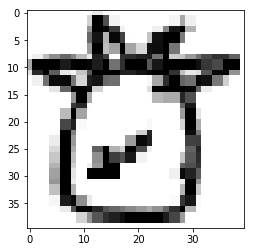

pear


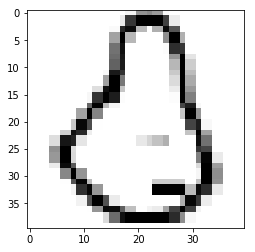

apple


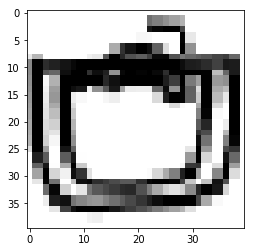

pool


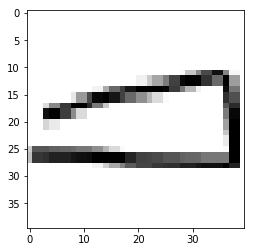

rollerskates


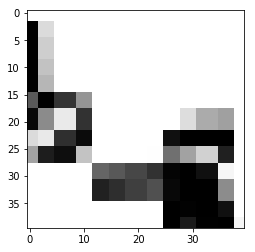

moustache


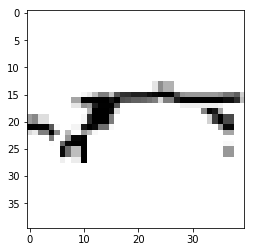

mouth


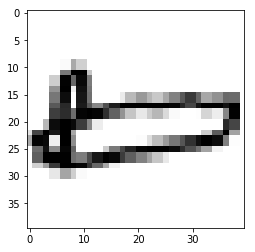

scorpion


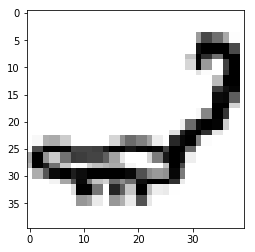

penguin


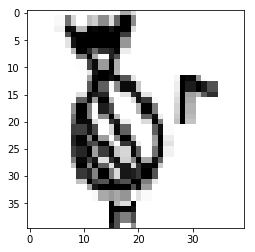

skull


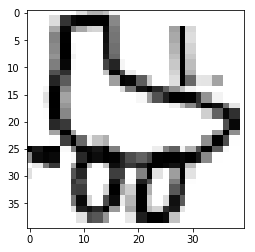

nail


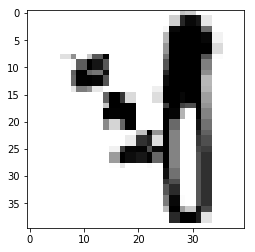

pineapple


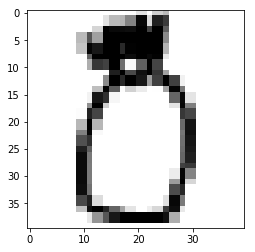

rifle


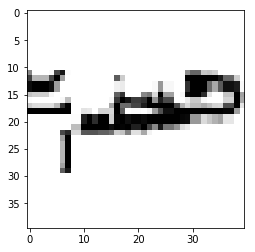

skull


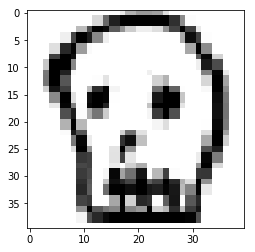

rabbit


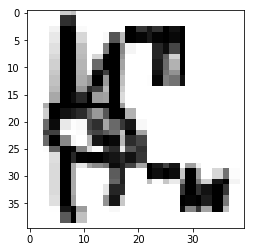

pencil


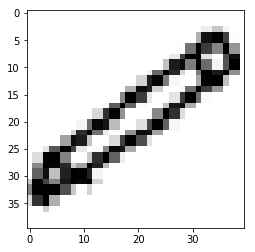

rifle


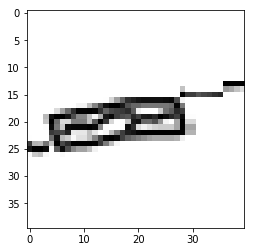

shovel


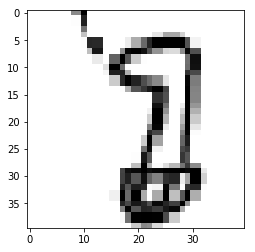

nose


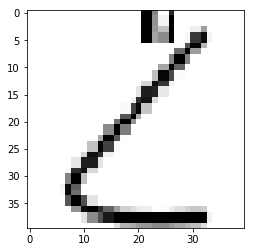

rifle


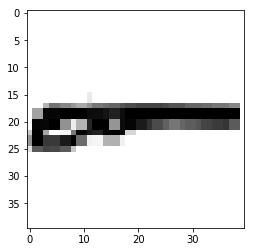

sailboat


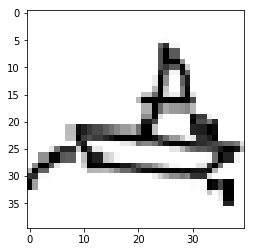

mug


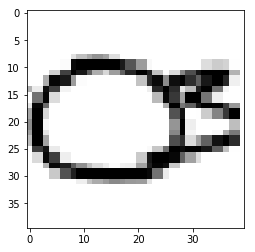

mouth


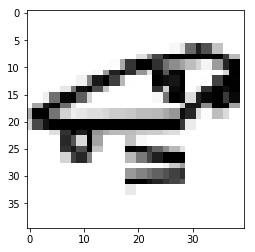

pool


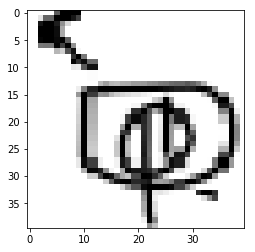

sink


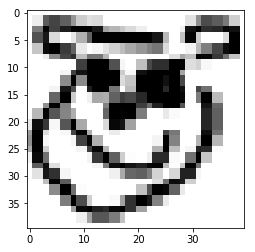

mouth


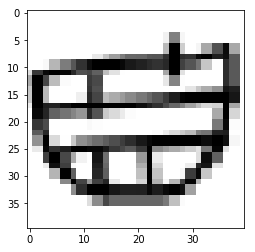

mouth


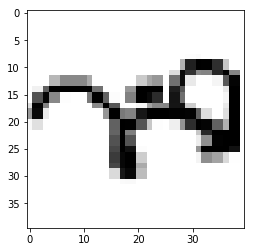

shovel


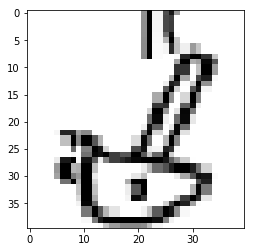

nose


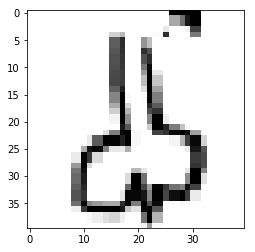

rifle


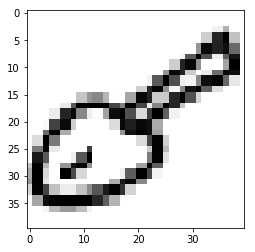

pineapple


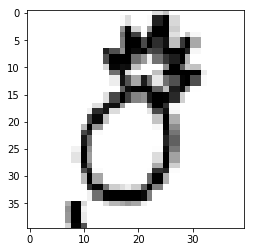

nail


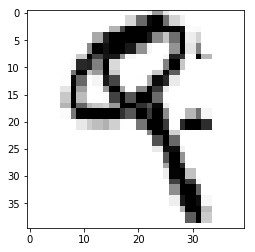

pencil


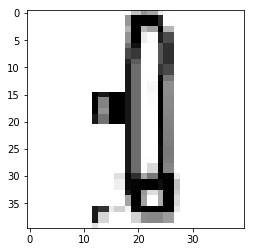

octagon


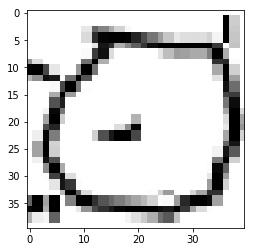

parrot


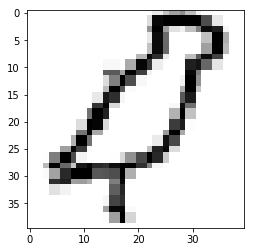

rifle


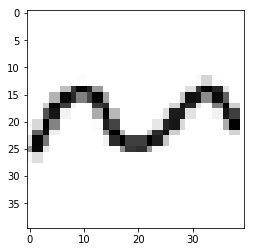

skateboard


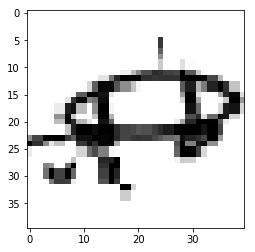

shovel


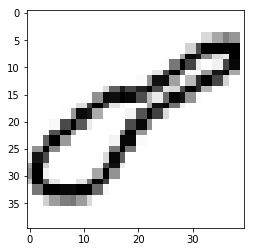

pool


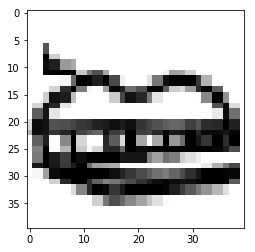

mug


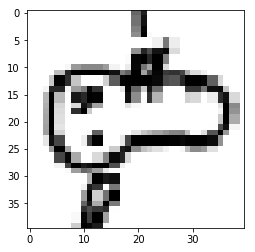

moustache


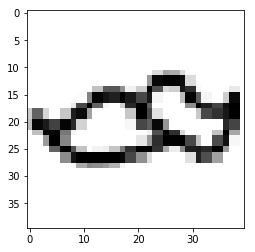

mouth


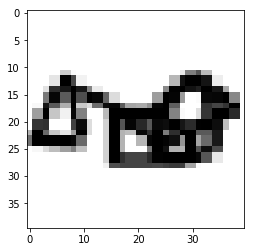

pillow


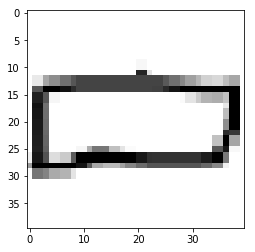

paintbrush


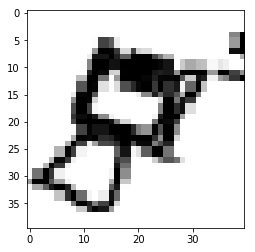

spoon


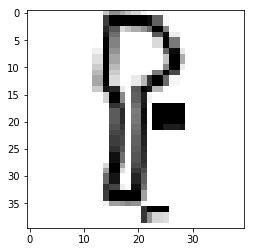

pencil


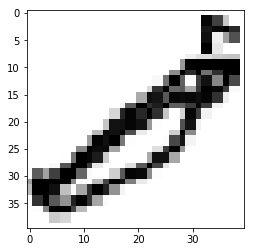

pear


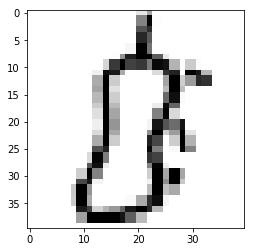

skull


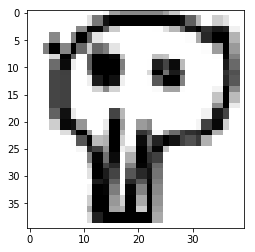

paintbrush


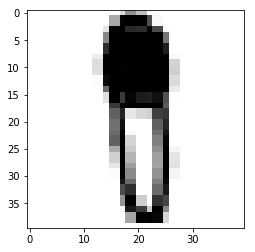

mouth


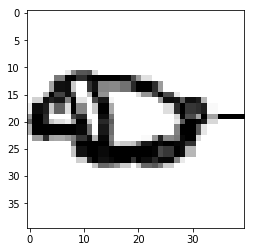

sailboat


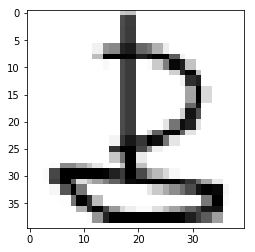

mouth


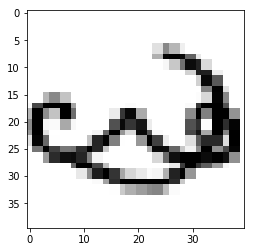

sailboat


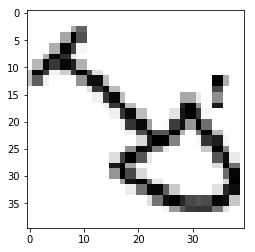

pineapple


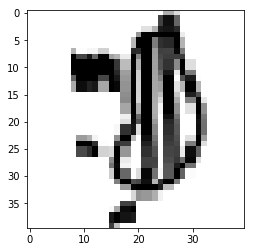

rifle


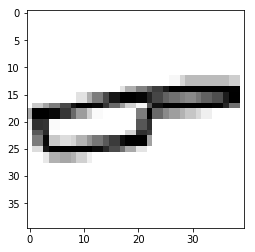

sailboat


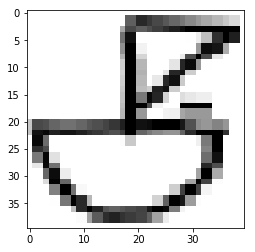

nail


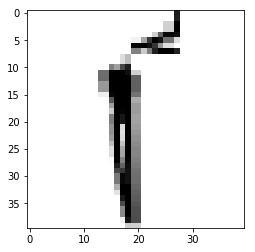

rifle


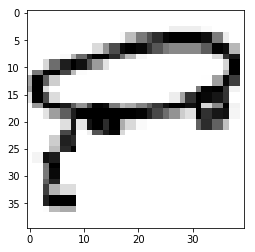

nose


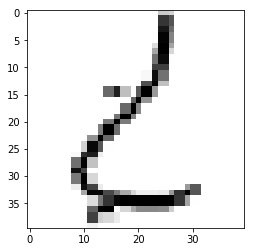

mouth


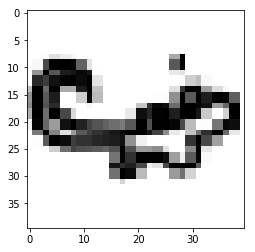

octagon


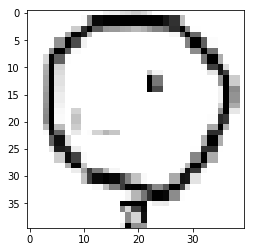

sailboat


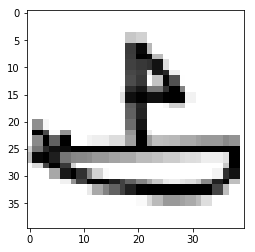

rifle


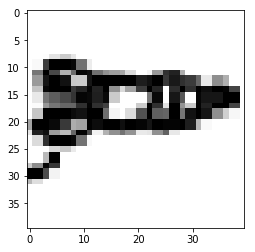

shovel


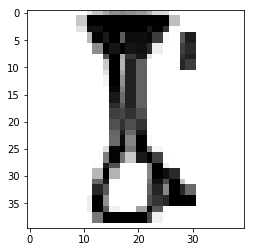

sailboat


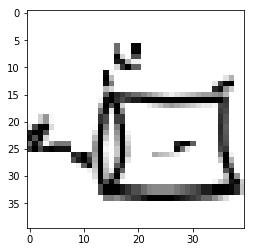

pool


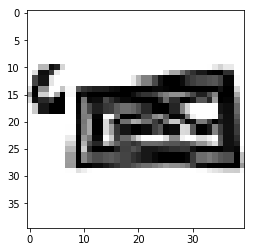

nail


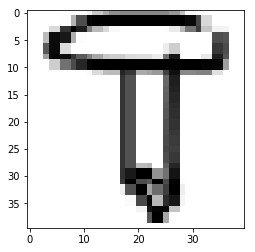

pool


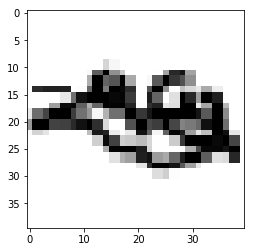

octagon


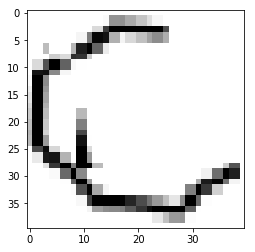

pool


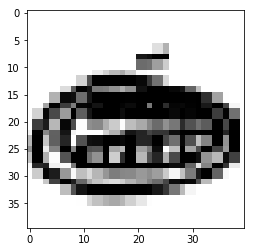

mouth


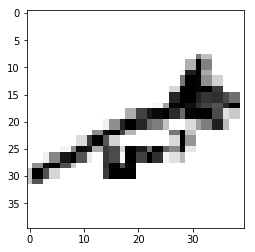

pear


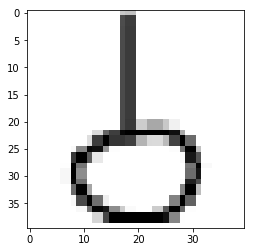

pool


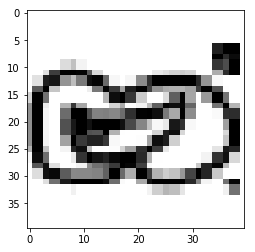

sailboat


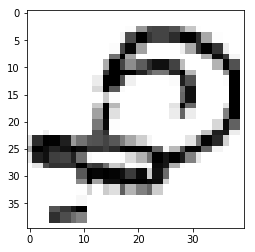

apple


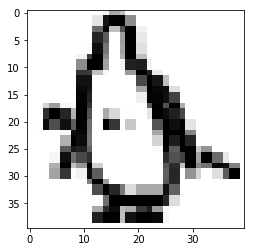

pineapple


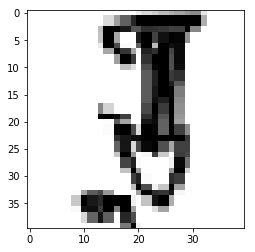

moustache


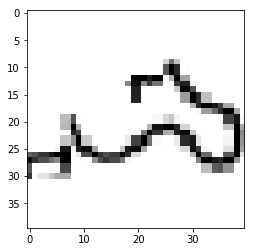

pineapple


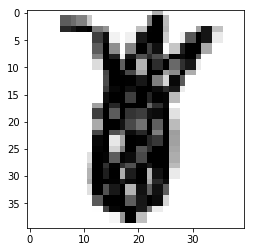

rollerskates


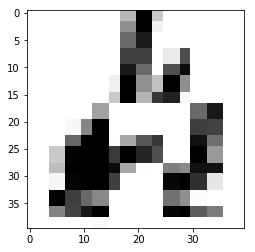

mouth


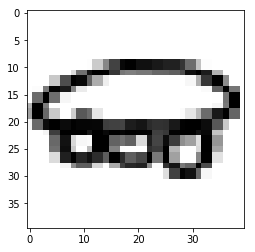

scorpion


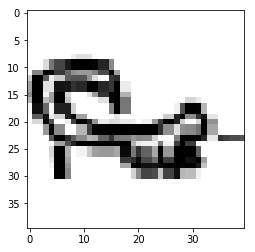

nail


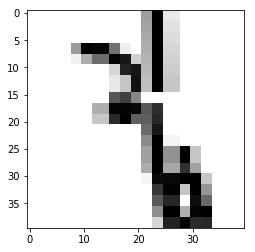

mug


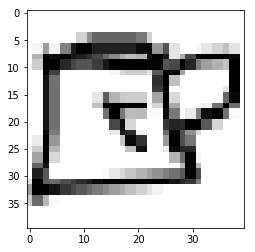

nail


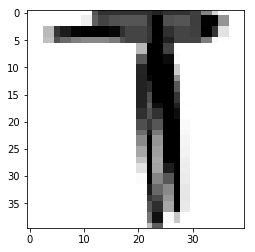

penguin


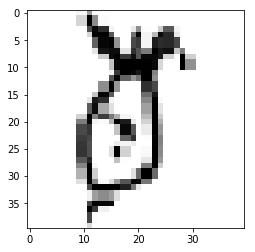

pool


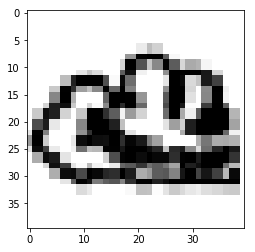

octagon


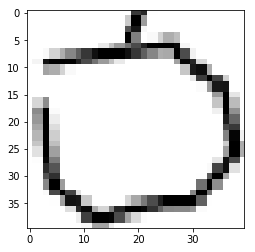

mug


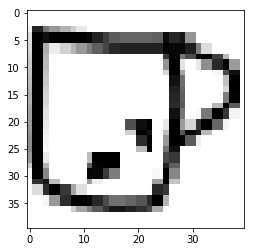

rifle


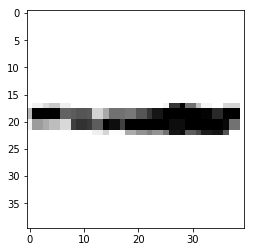

mug


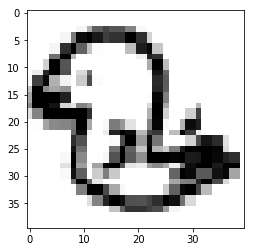

parrot


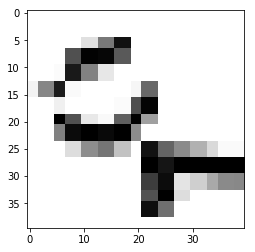

sailboat


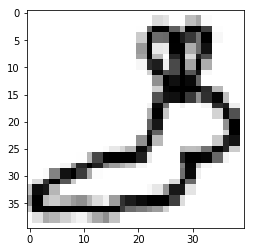

mug


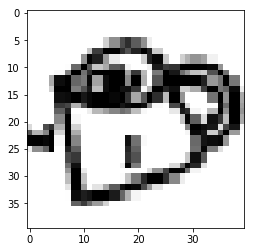

pineapple


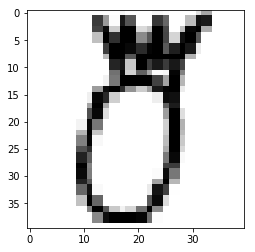

mouth


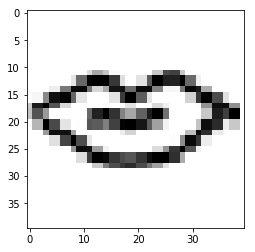

scorpion


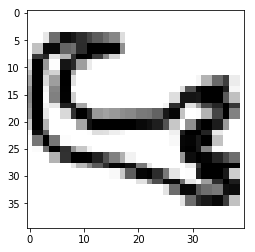

rabbit


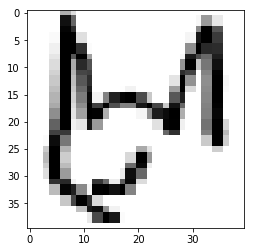

empty


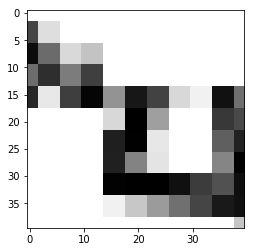

mug


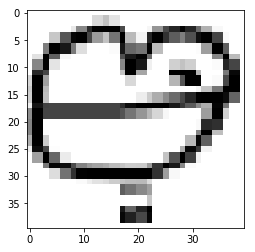

panda


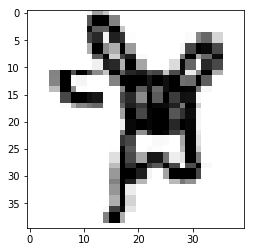

sailboat


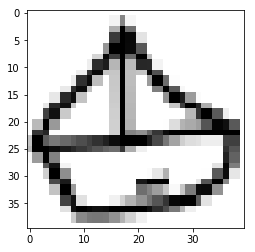

moustache


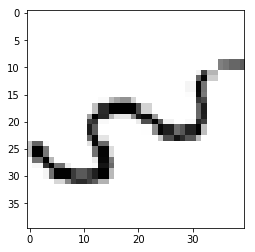

octagon


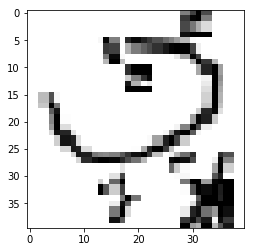

mouth


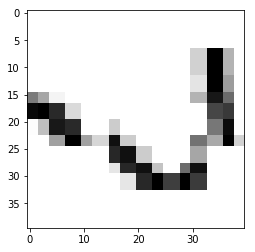

nail


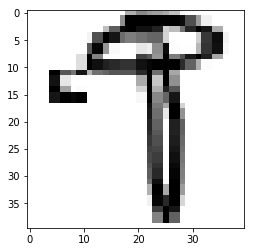

apple


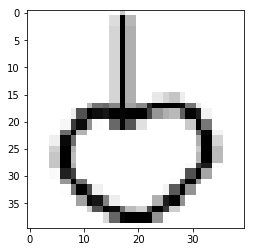

pineapple


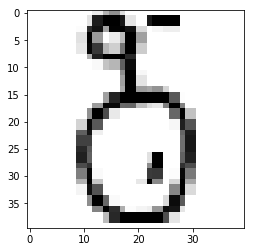

pool


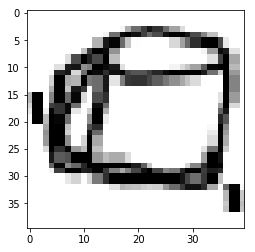

rifle


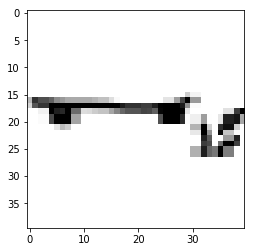

moustache


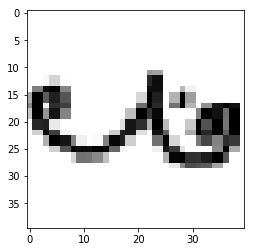

sink


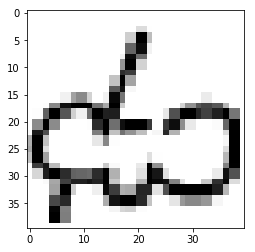

mouth


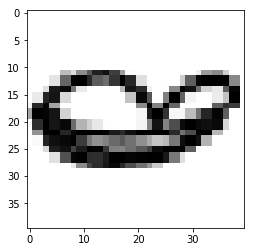

nail


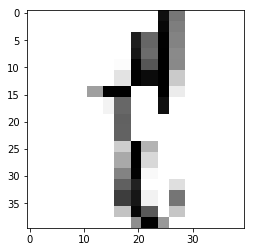

scorpion


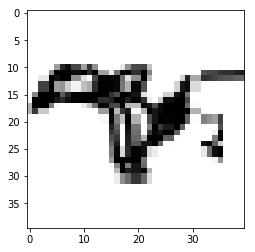

moustache


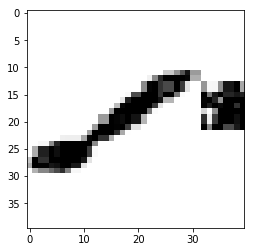

shovel


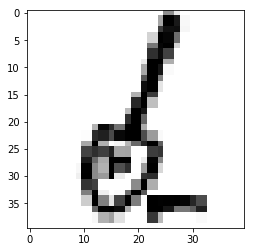

pineapple


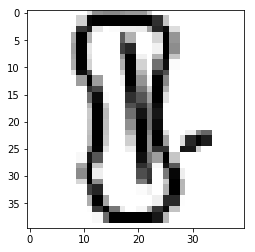

rifle


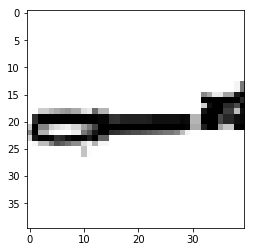

mouth


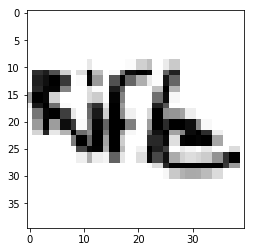

empty


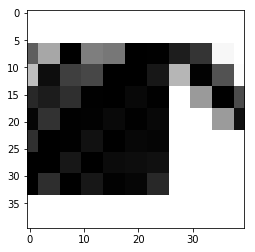

nail


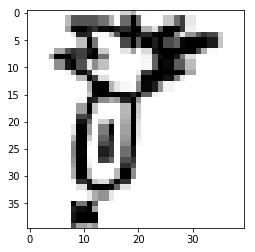

sailboat


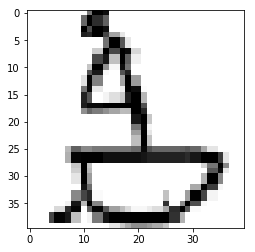

pillow


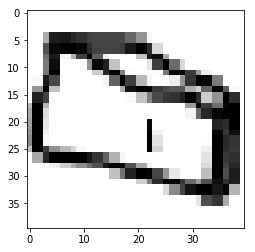

moustache


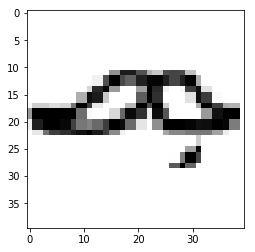

apple


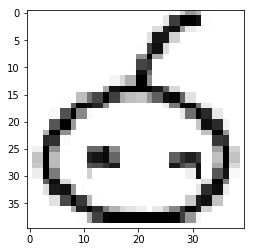

octagon


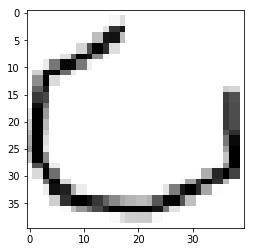

sailboat


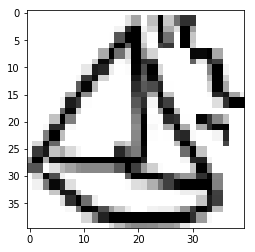

pool


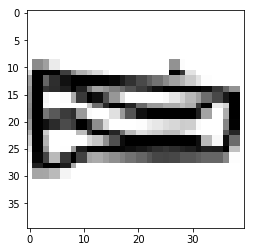

sink


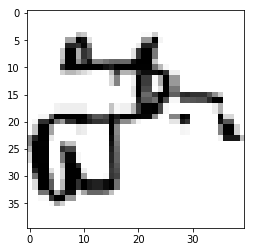

pool


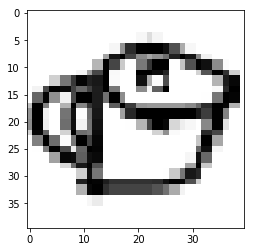

rabbit


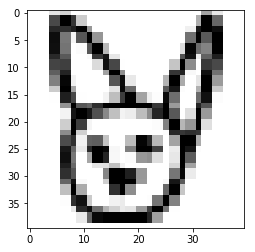

pillow


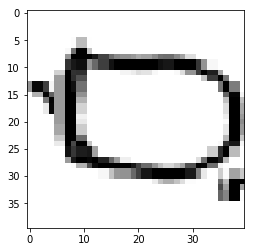

pencil


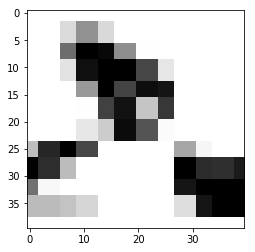

nail


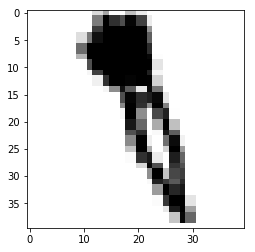

mouth


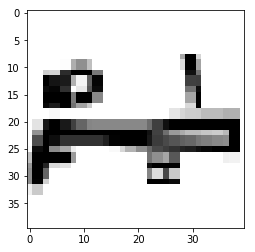

moustache


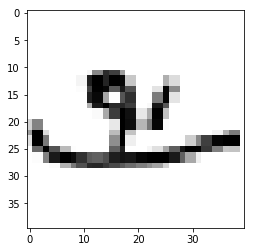

scorpion


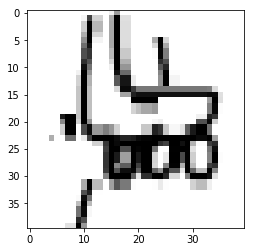

mug


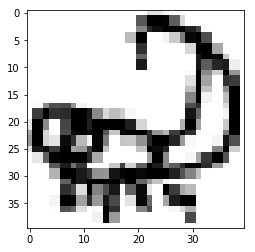

pillow


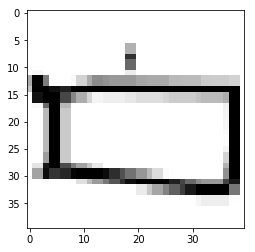

apple


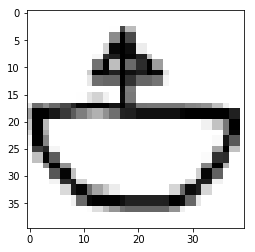

nail


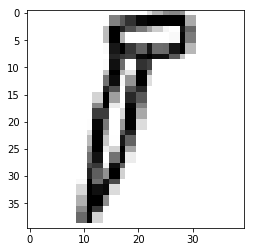

sink


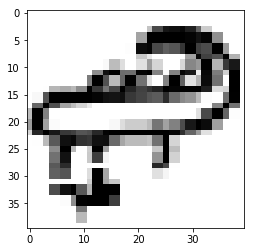

paintbrush


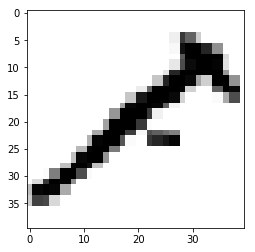

apple


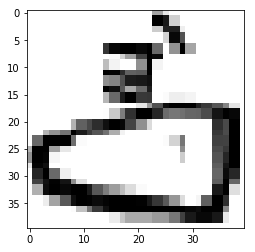

rifle


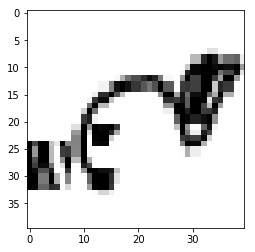

apple


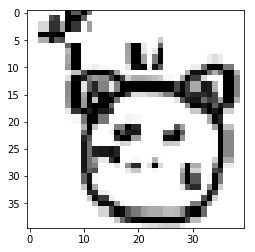

apple


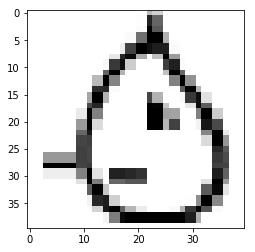

pillow


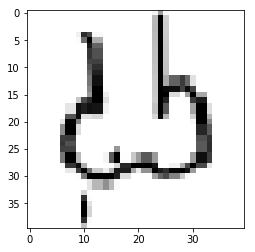

mouth


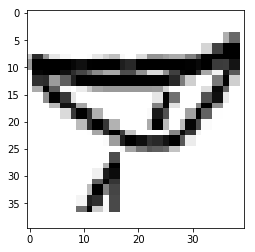

pencil


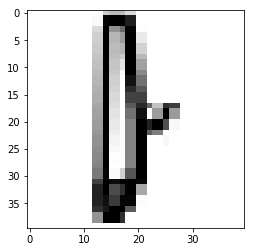

moustache


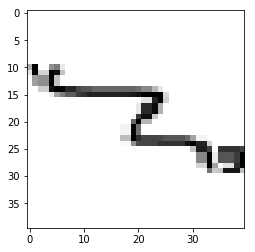

rifle


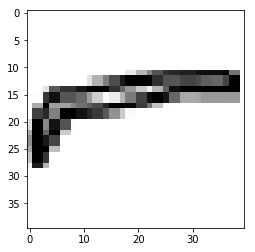

pineapple


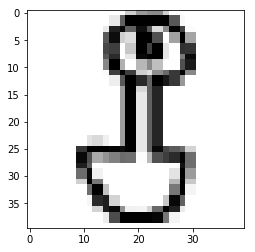

moustache


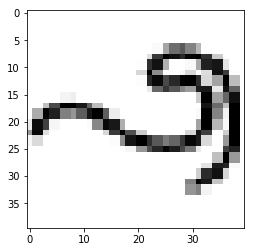

nail


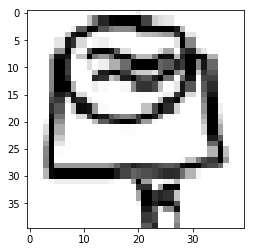

nail


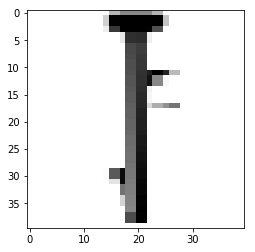

apple


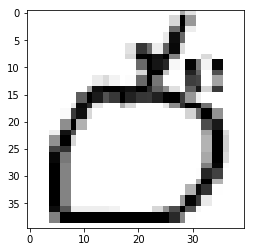

nail


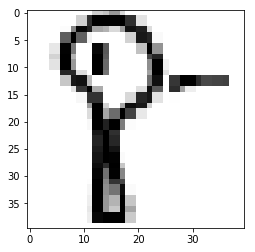

scorpion


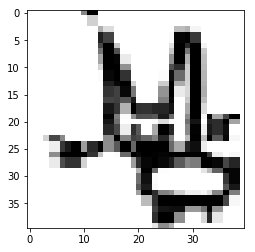

octagon


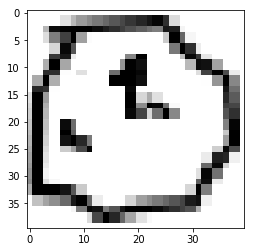

mouth


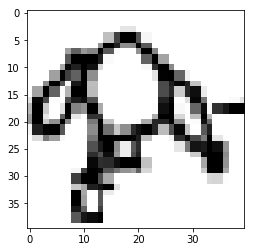

nose


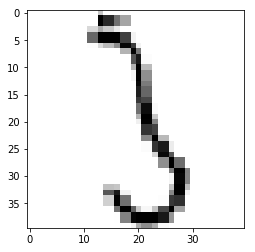

moustache


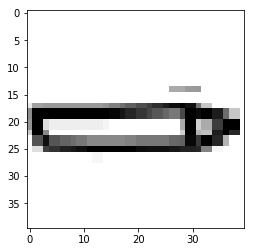

mouth


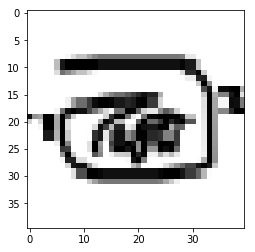

rifle


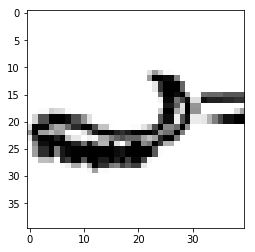

penguin


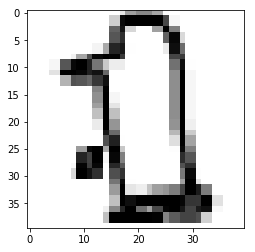

rifle


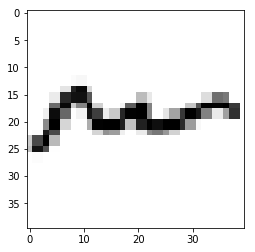

empty


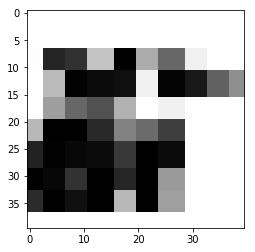

mouth


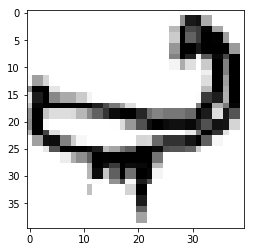

octagon


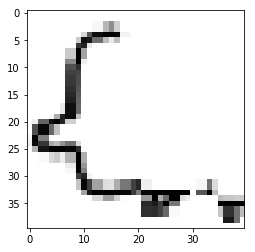

pineapple


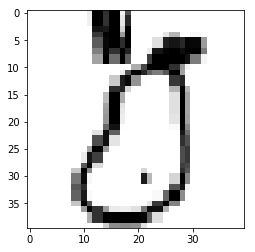

rifle


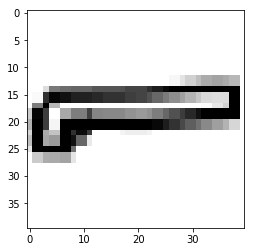

penguin


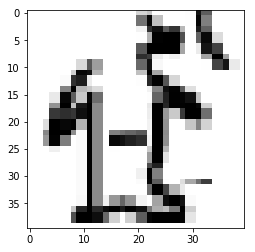

pineapple


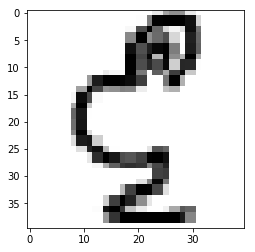

nail


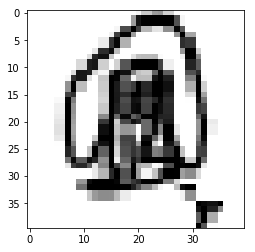

nail


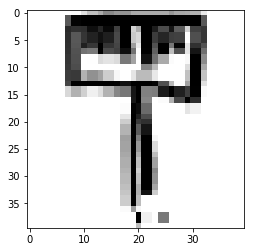

rifle


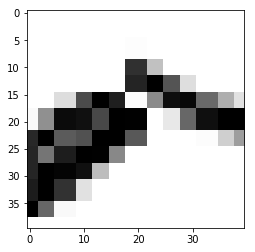

moustache


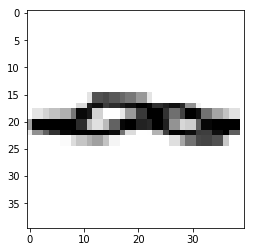

empty


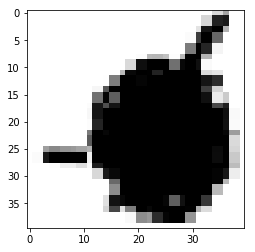

pillow


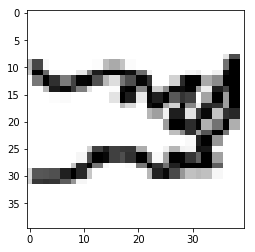

penguin


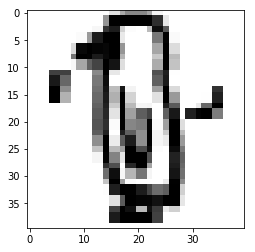

sailboat


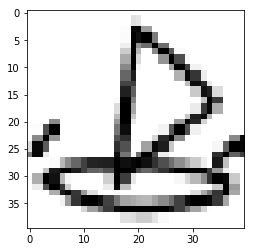

rabbit


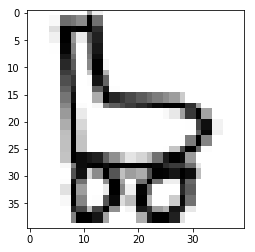

pineapple


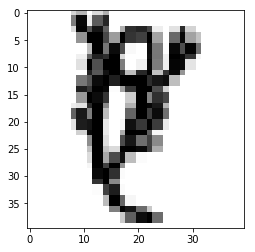

pillow


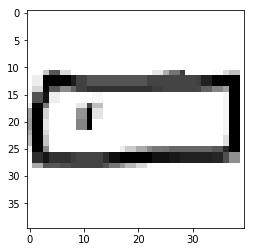

nail


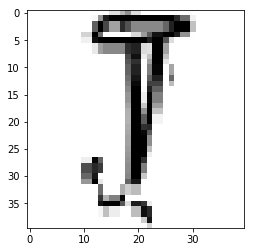

sailboat


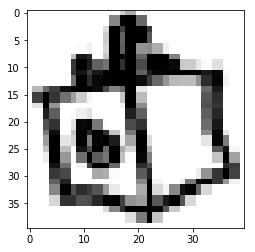

pool


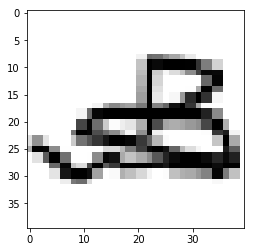

octagon


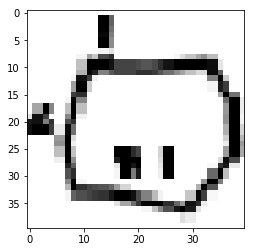

empty


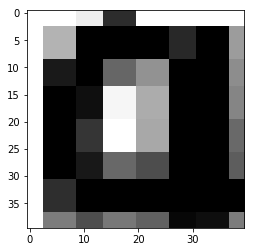

pineapple


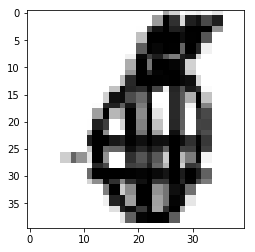

penguin


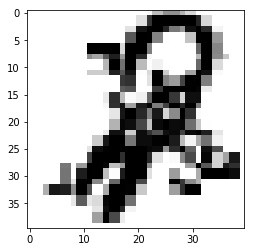

sailboat


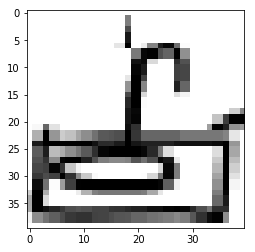

mouth


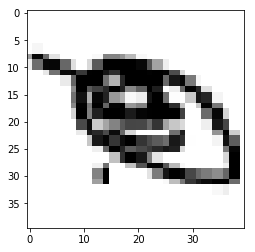

pineapple


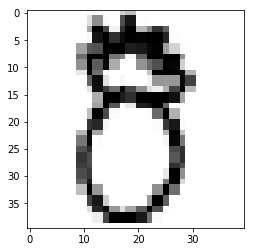

skull


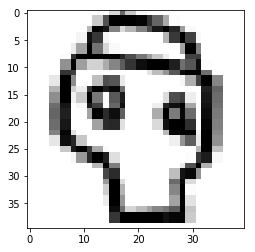

pillow


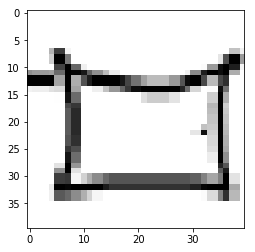

nail


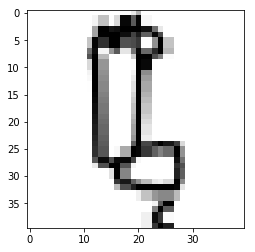

mouth


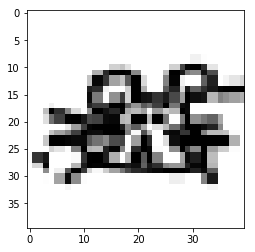

mouth


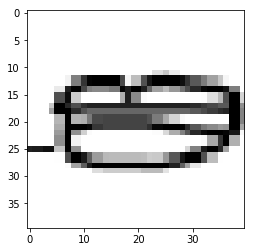

mouth


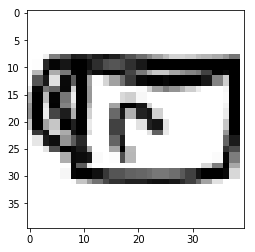

rifle


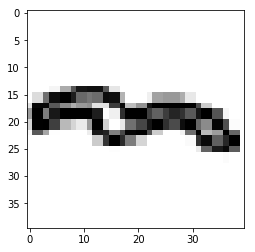

rollerskates


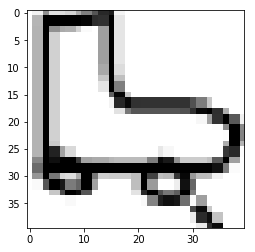

skull


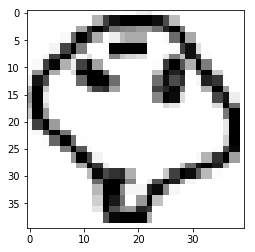

pool


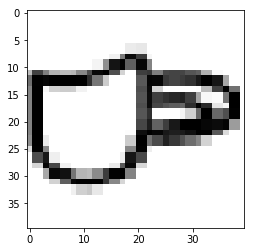

scorpion


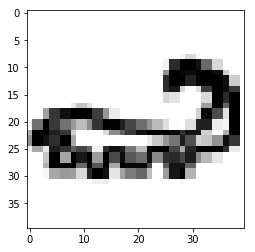

skateboard


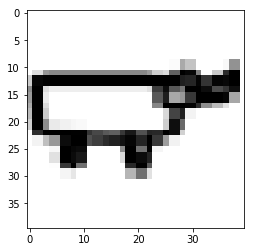

nail


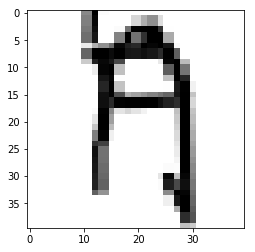

skateboard


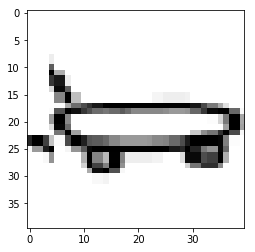

pencil


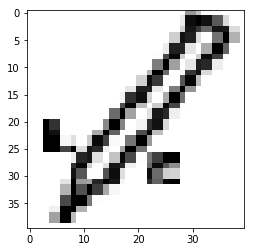

pillow


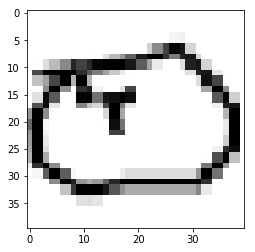

sailboat


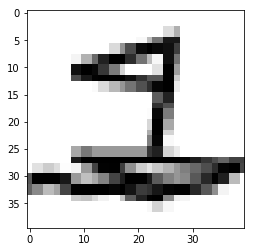

rollerskates


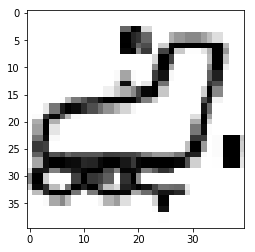

moustache


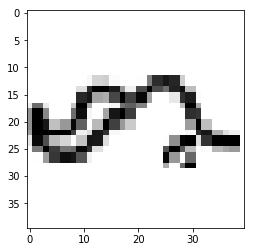

pool


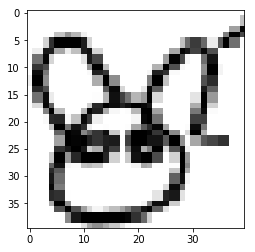

pillow


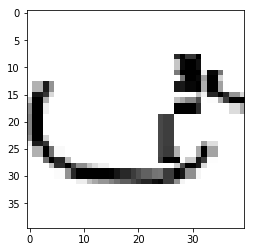

mouth


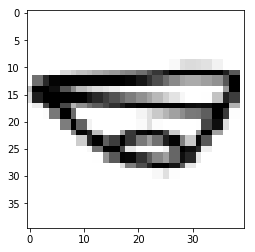

rifle


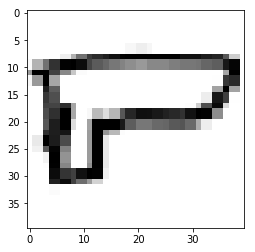

scorpion


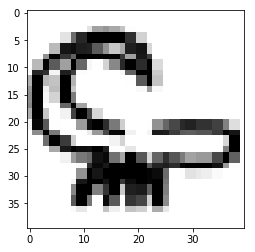

mug


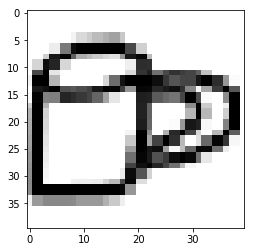

nail


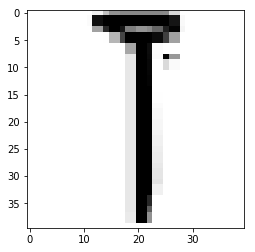

empty


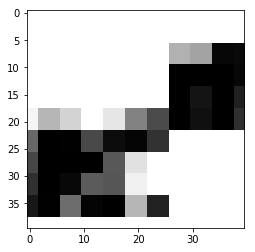

pineapple


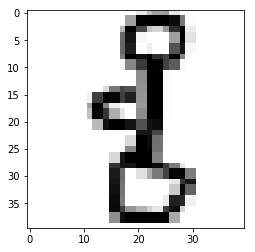

nail


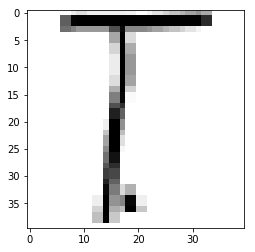

mug


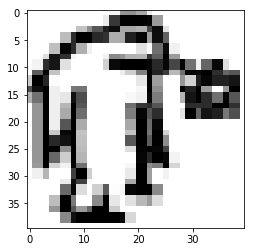

mouth


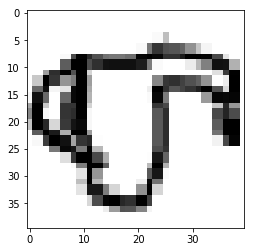

moustache


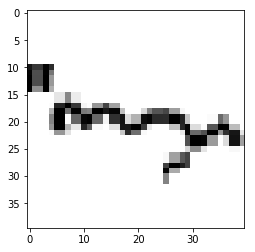

pool


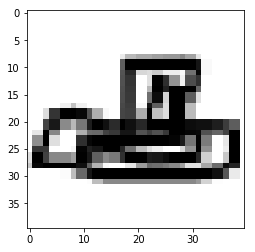

sailboat


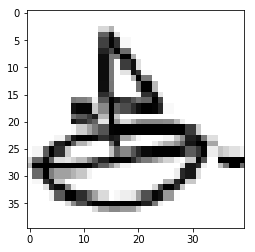

apple


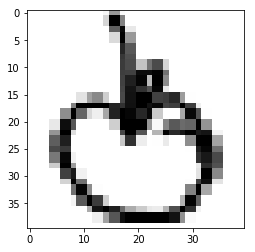

scorpion


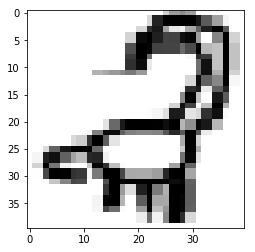

spoon


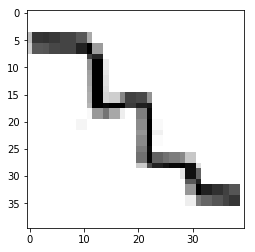

nose


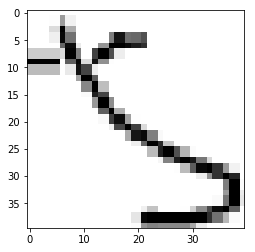

skateboard


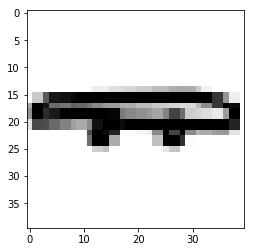

apple


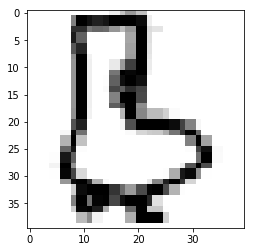

rollerskates


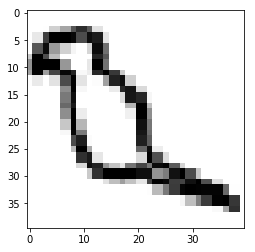

mouth


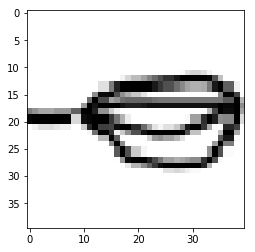

pillow


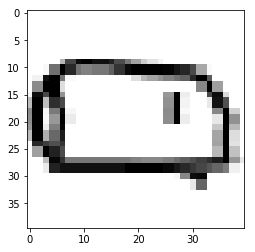

octagon


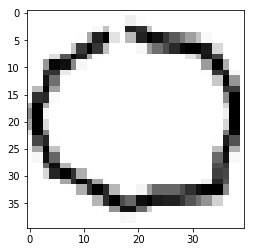

scorpion


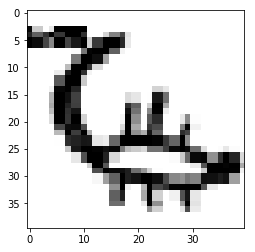

apple


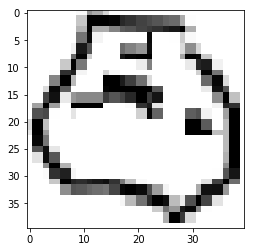

rifle


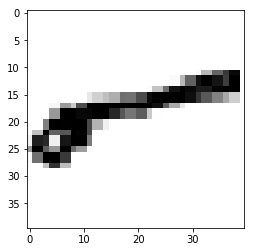

octagon


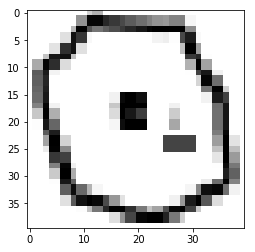

shovel


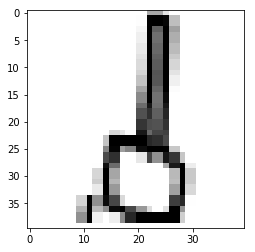

nose


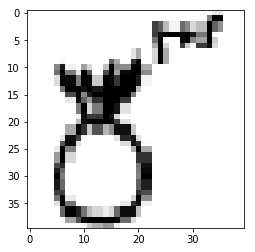

penguin


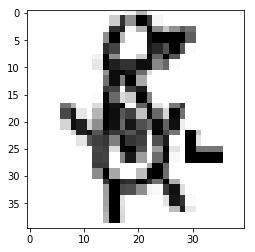

pineapple


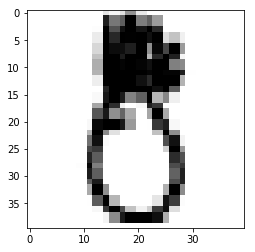

rifle


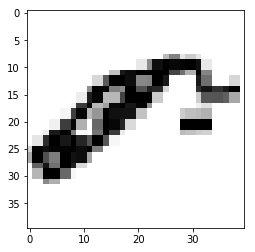

screwdriver


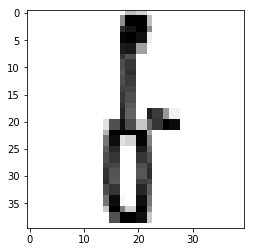

pineapple


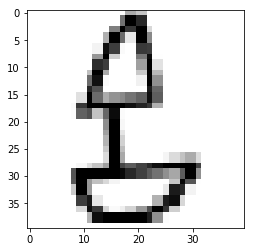

nail


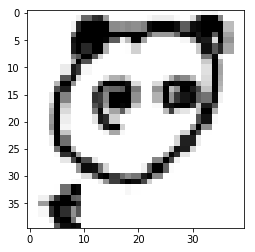

scorpion


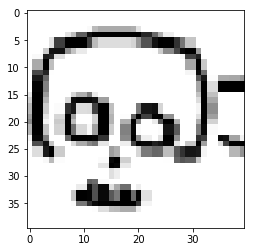

pineapple


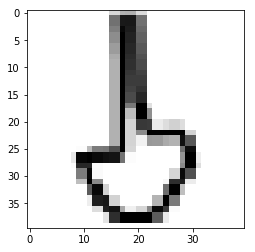

mouth


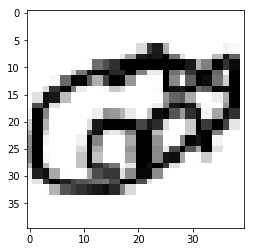

sink


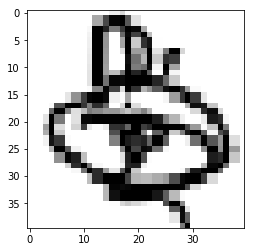

nail


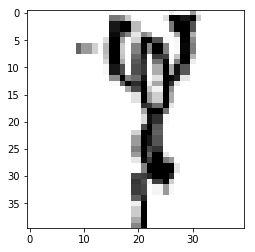

pineapple


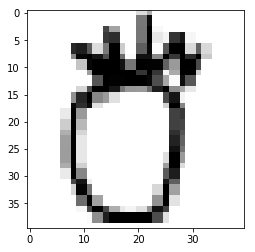

rifle


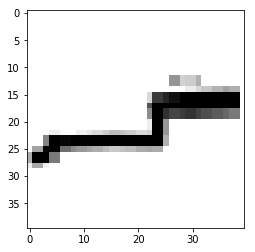

octagon


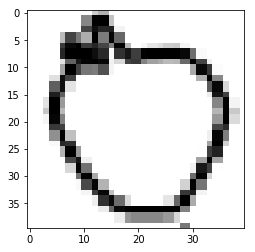

pool


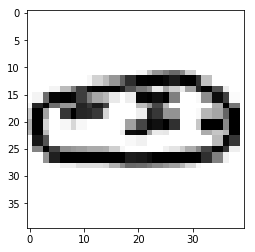

nail


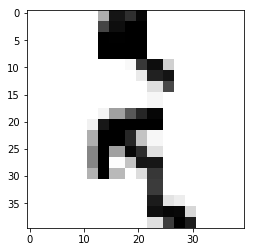

apple


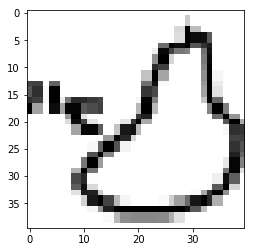

pineapple


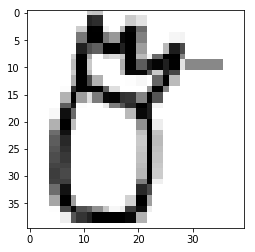

pencil


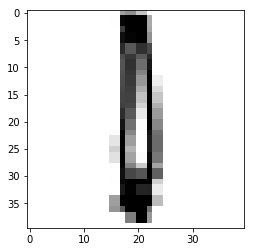

pool


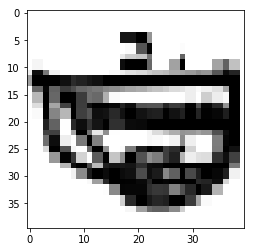

mouth


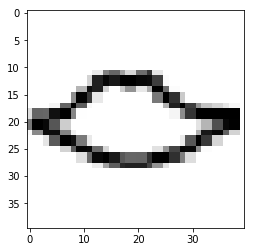

peanut


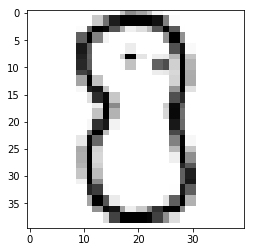

moustache


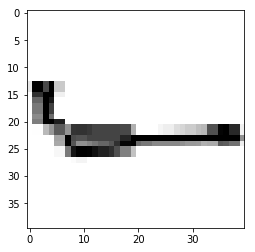

nail


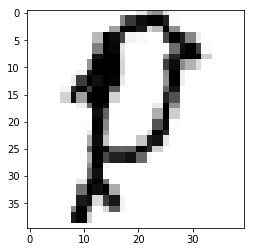

nail


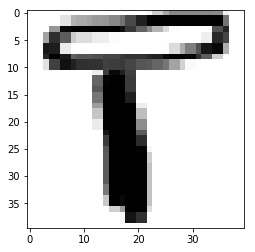

mouth


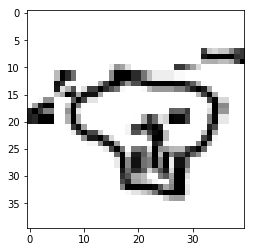

penguin


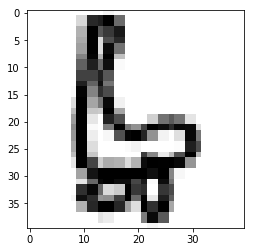

nose


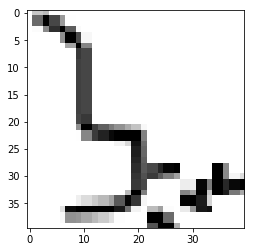

mouth


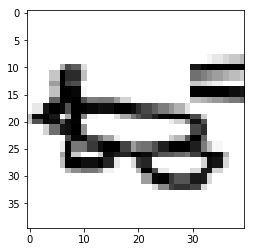

mouth


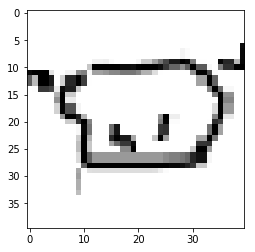

apple


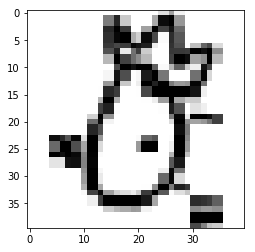

rifle


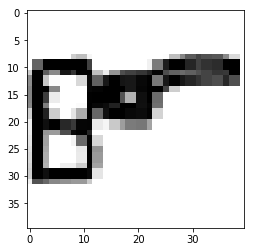

octagon


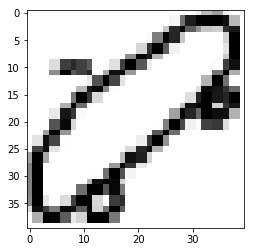

penguin


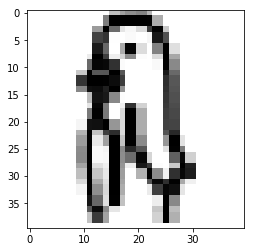

skateboard


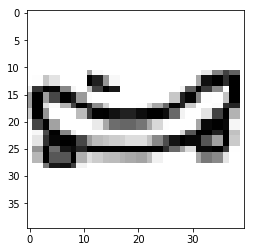

moustache


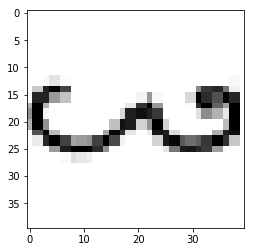

rifle


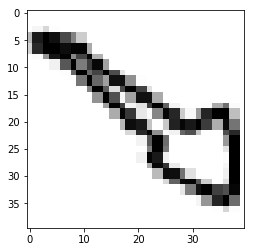

mouth


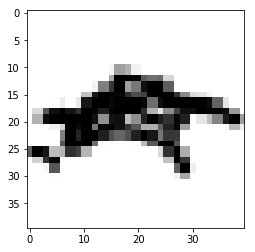

paintbrush


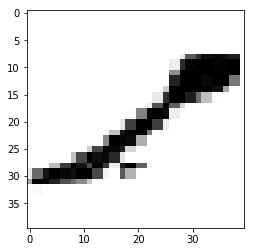

pineapple


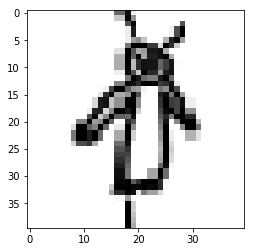

mug


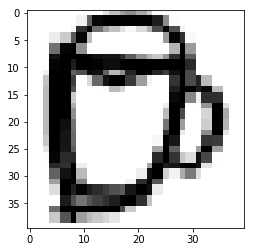

pineapple


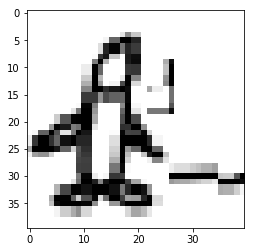

moustache


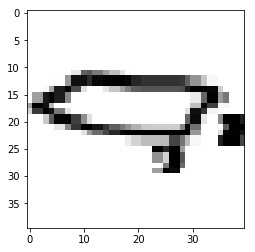

mouth


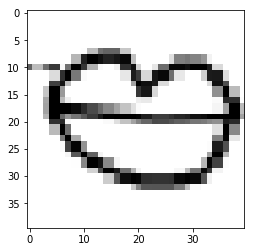

pencil


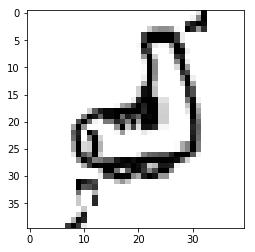

apple


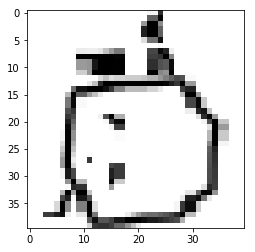

mouth


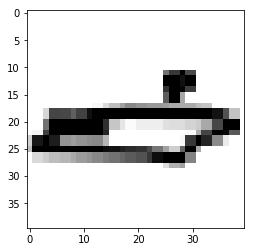

rifle


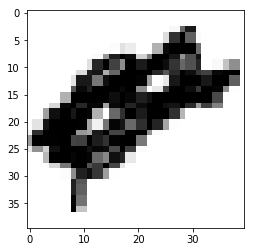

mouth


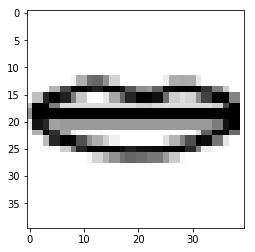

nose


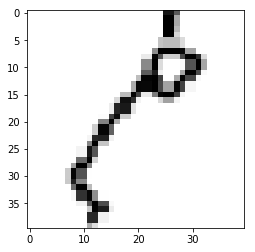

penguin


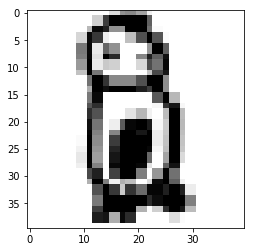

pool


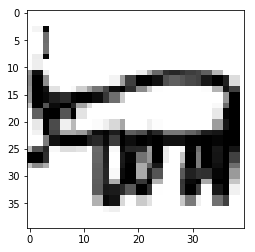

penguin


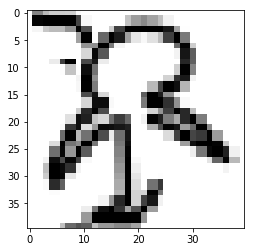

skateboard


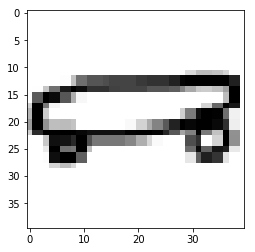

pineapple


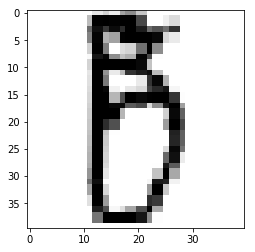

pencil


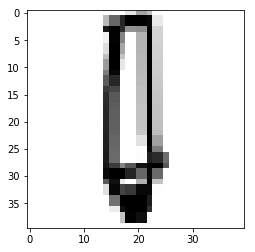

skateboard


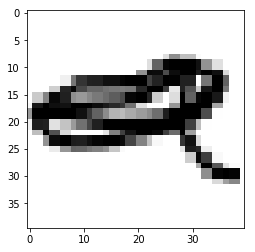

scorpion


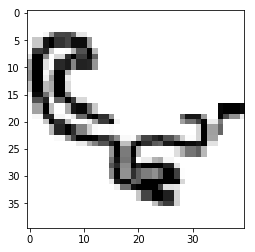

moustache


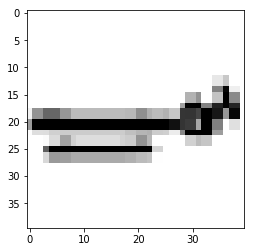

nail


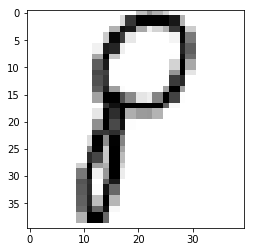

apple


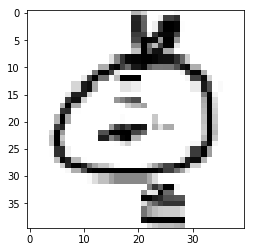

nose


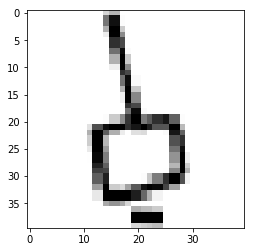

octagon


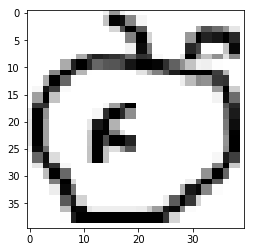

mug


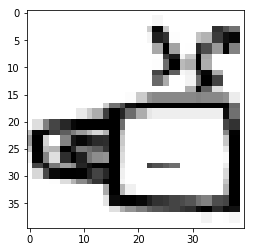

skateboard


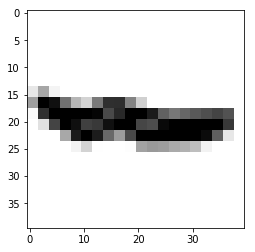

rifle


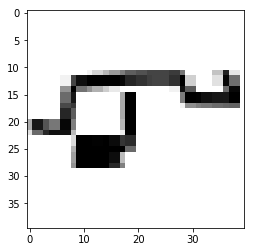

skateboard


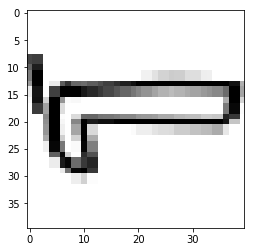

scorpion


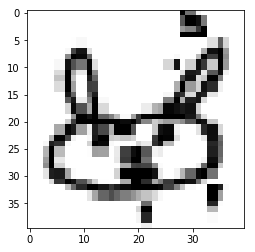

octagon


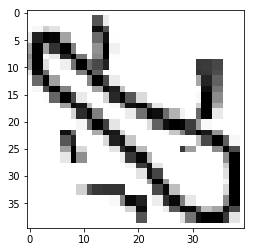

skateboard


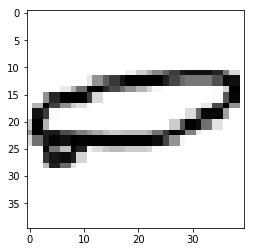

pineapple


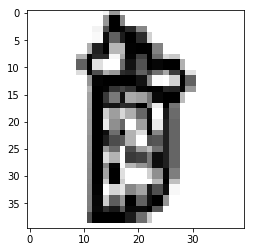

pineapple


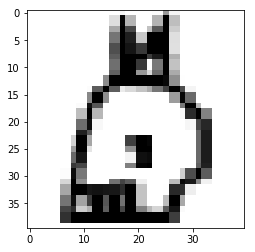

pool


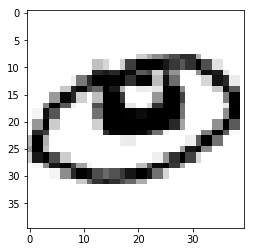

octagon


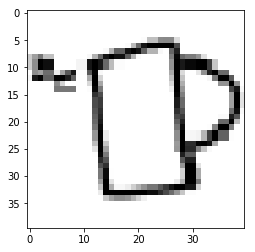

parrot


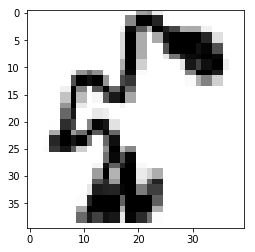

mouth


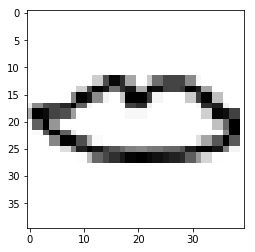

mouth


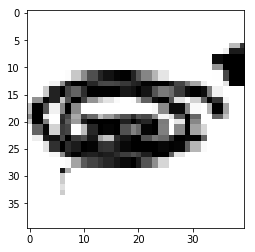

rifle


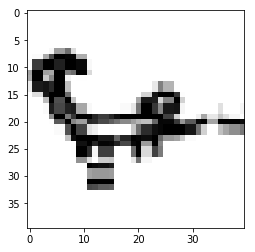

rollerskates


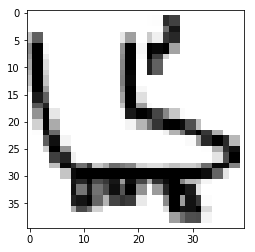

shovel


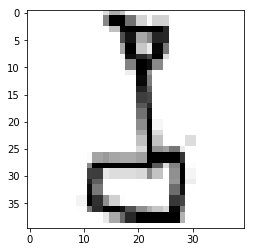

nail


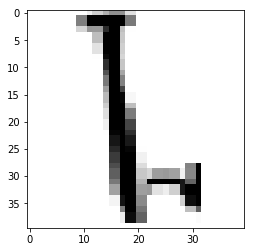

rifle


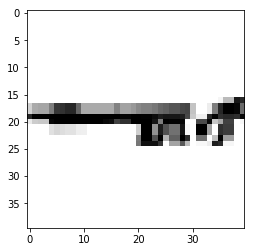

pineapple


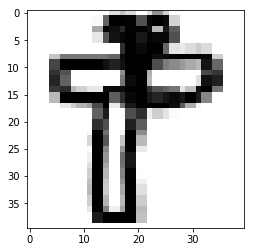

rifle


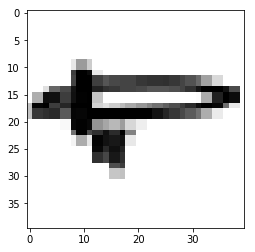

nail


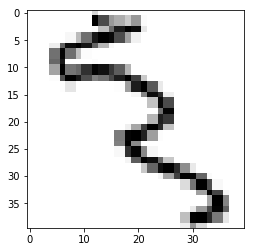

paintbrush


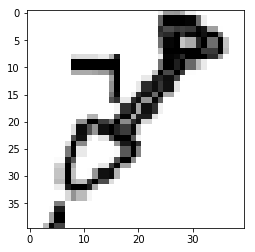

nail


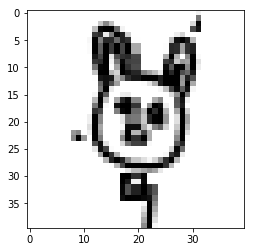

mouth


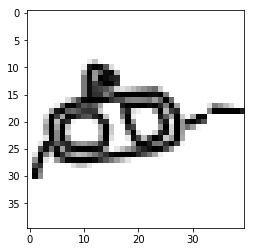

pineapple


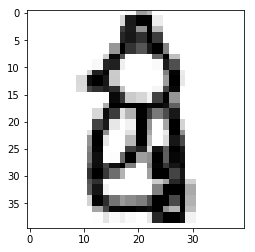

octagon


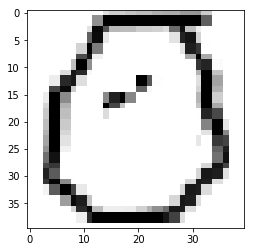

skull


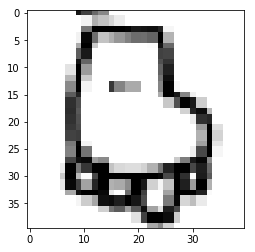

pineapple


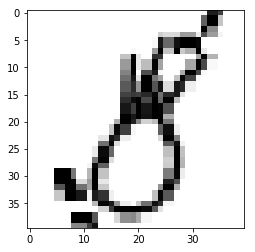

mouth


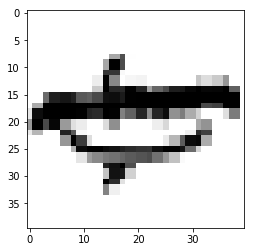

pillow


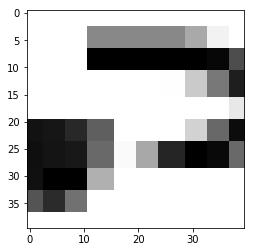

moustache


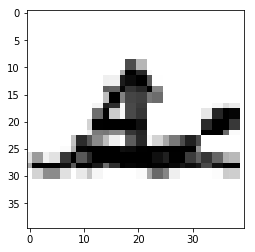

mouth


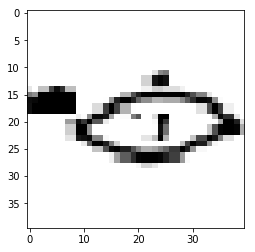

mouth


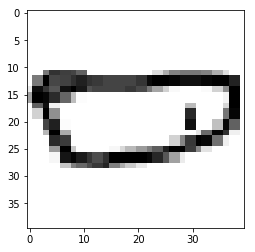

sailboat


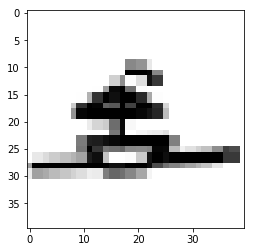

nose


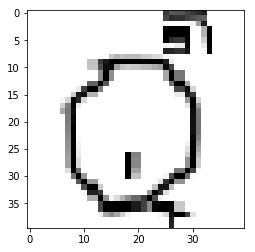

paintbrush


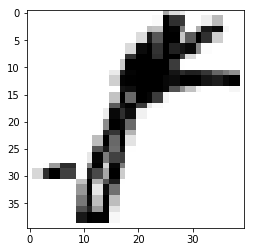

penguin


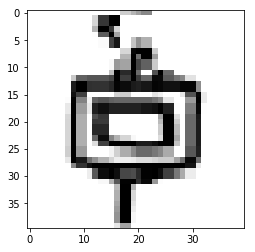

penguin


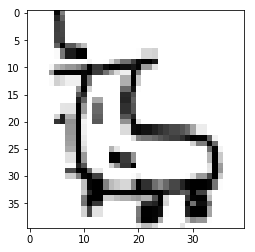

pineapple


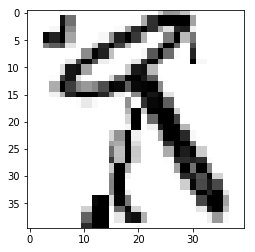

skateboard


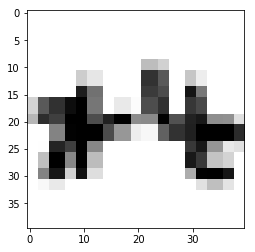

screwdriver


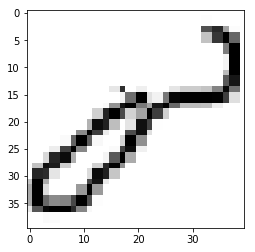

octagon


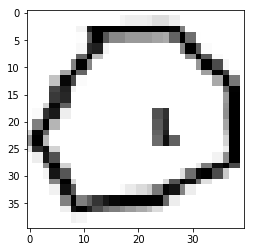

pineapple


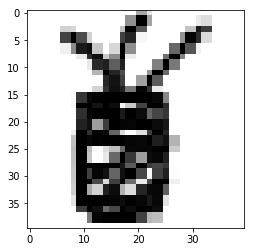

nail


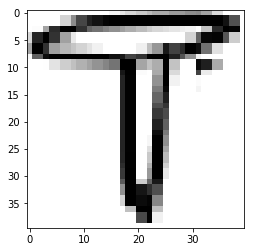

octagon


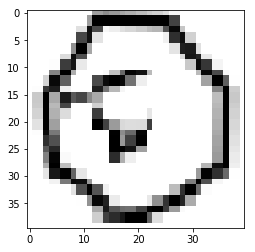

octagon


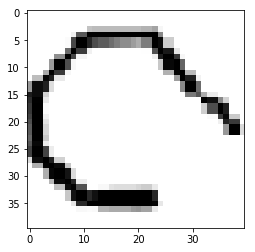

moustache


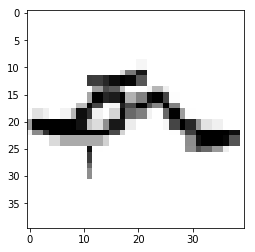

octagon


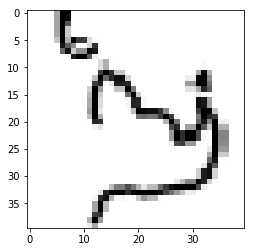

moustache


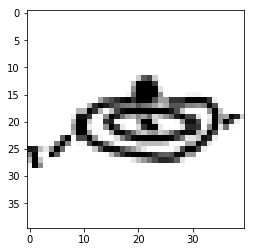

moustache


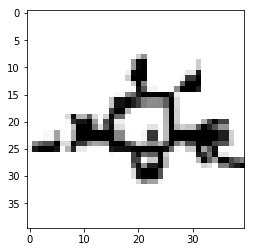

pear


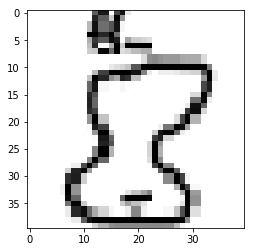

penguin


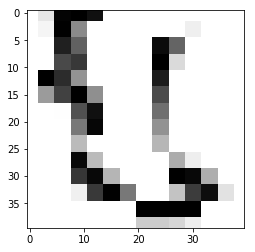

parrot


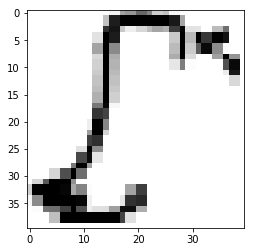

nose


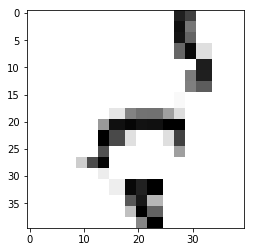

mouth


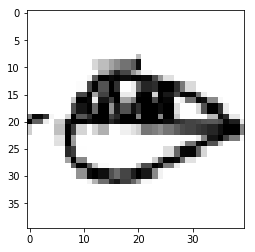

nail


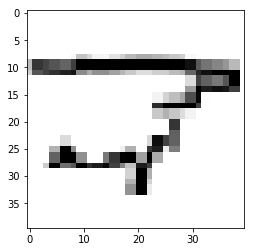

skateboard


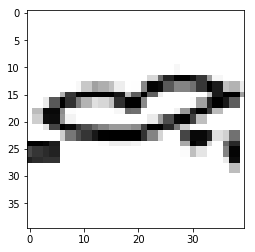

skateboard


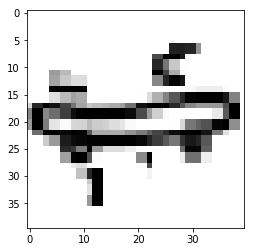

penguin


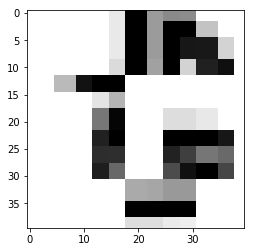

mouth


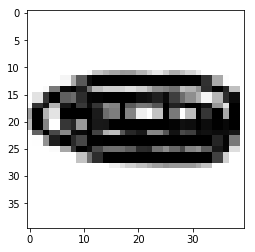

nose


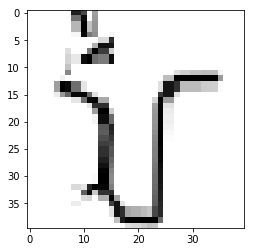

pool


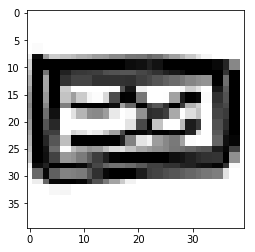

apple


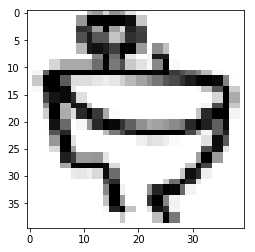

rifle


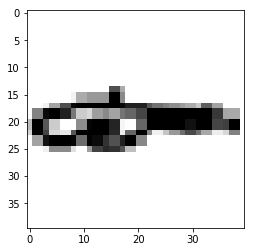

octagon


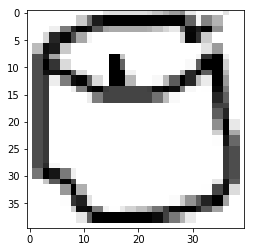

pineapple


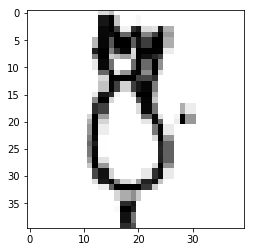

nail


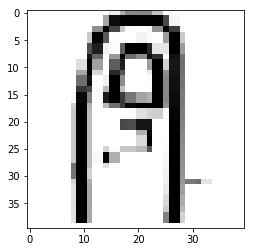

mug


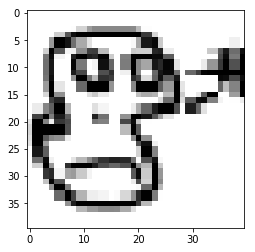

mouth


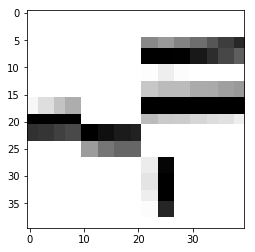

skateboard


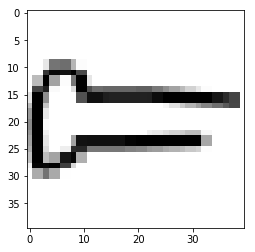

sailboat


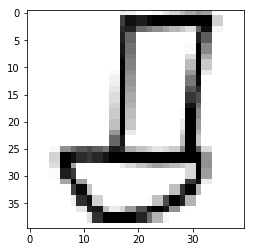

pineapple


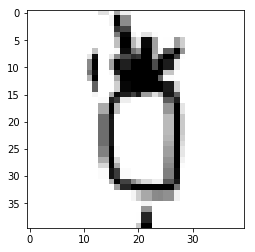

moustache


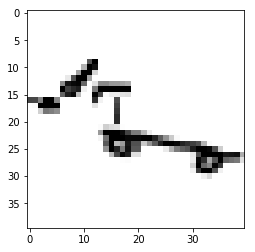

mouth


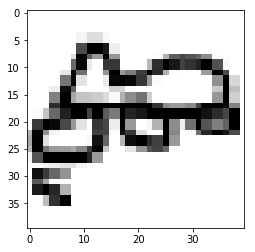

sailboat


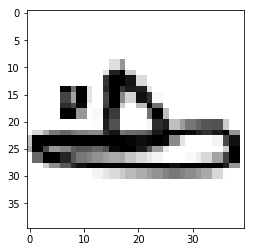

sailboat


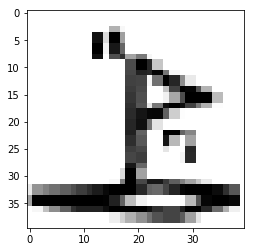

moustache


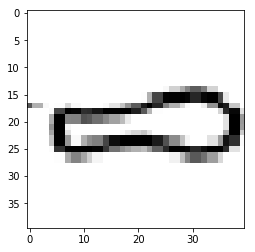

apple


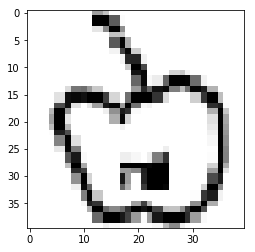

octagon


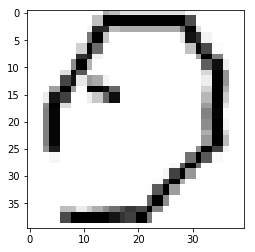

pencil


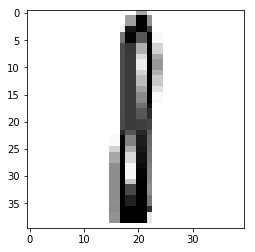

mouth


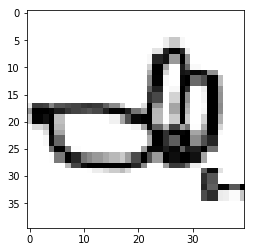

octagon


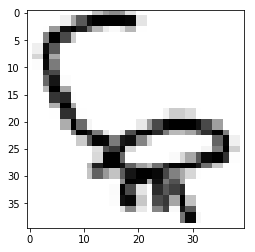

skateboard


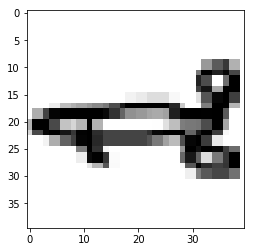

moustache


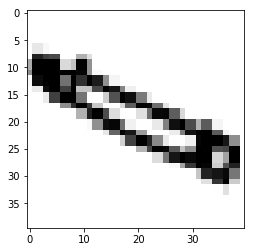

nail


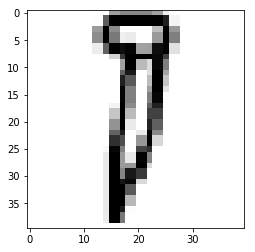

moustache


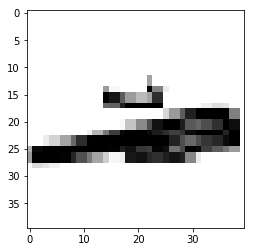

sink


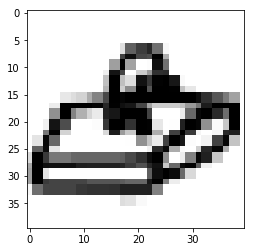

apple


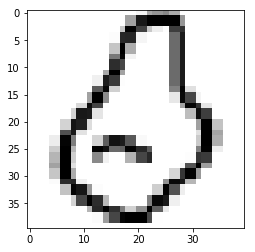

octagon


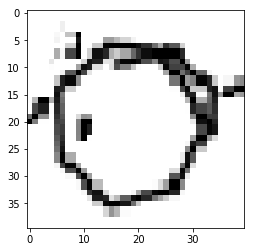

shovel


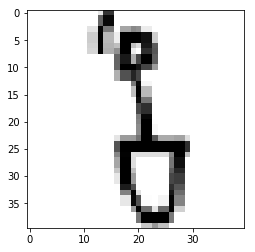

rabbit


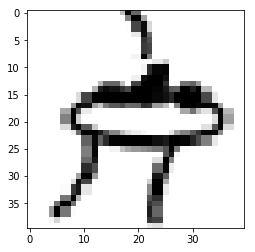

mouth


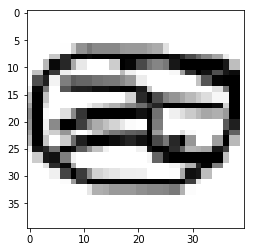

scorpion


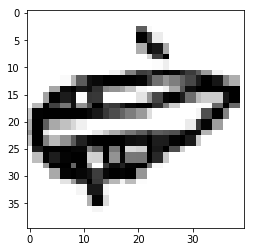

apple


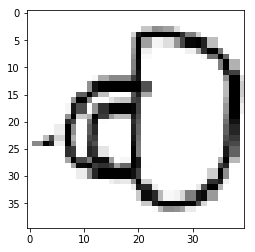

mouth


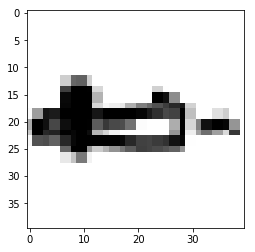

mouth


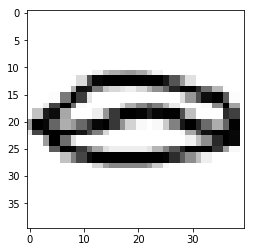

skull


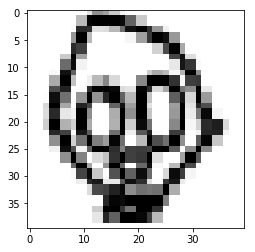

pineapple


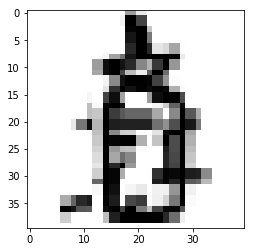

apple


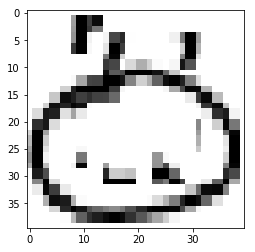

mouth


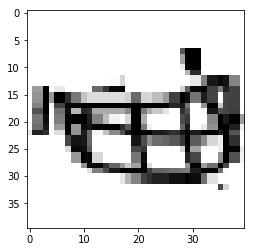

apple


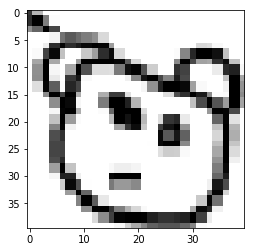

skateboard


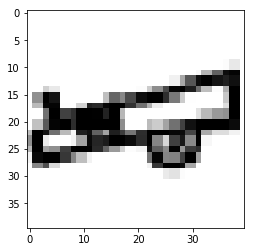

octagon


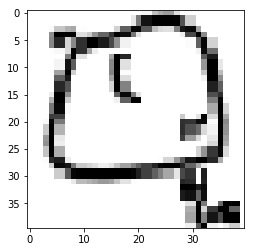

panda


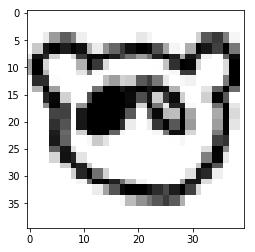

penguin


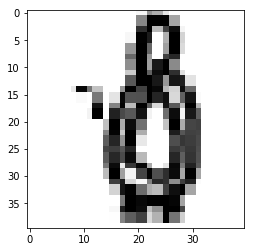

mouth


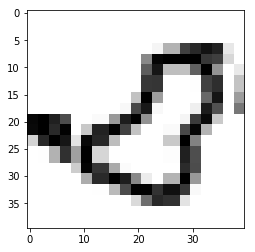

nail


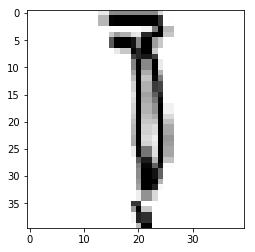

scorpion


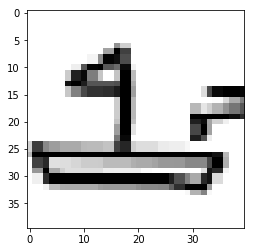

mouth


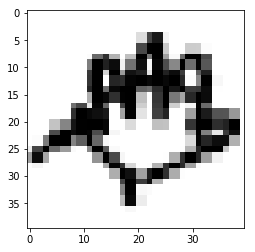

pencil


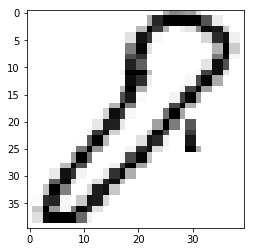

moustache


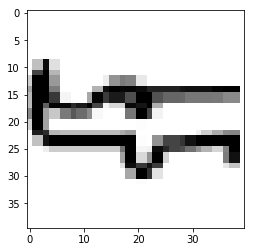

mouth


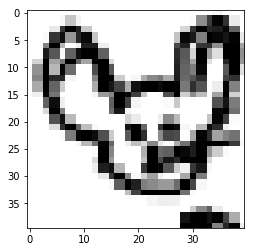

nail


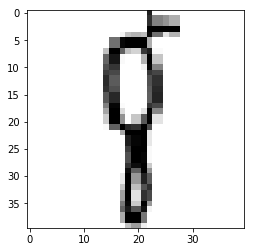

nail


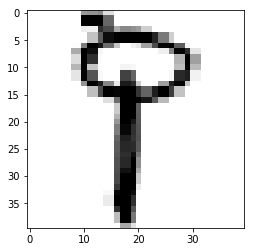

sailboat


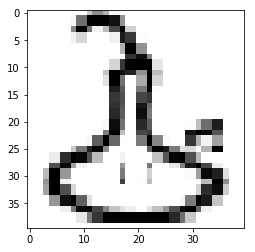

pool


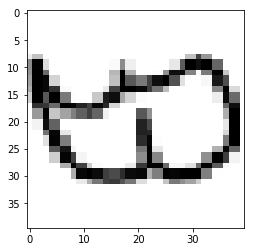

sink


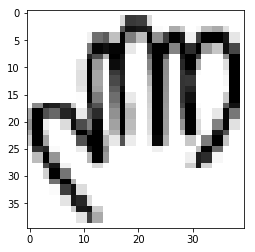

mouth


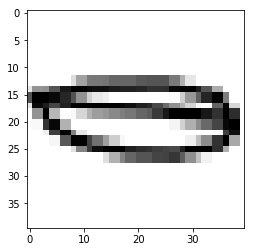

pear


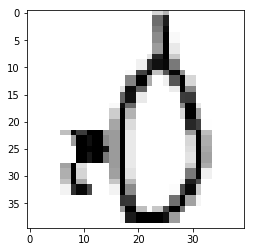

penguin


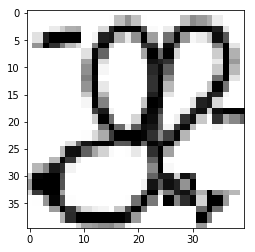

penguin


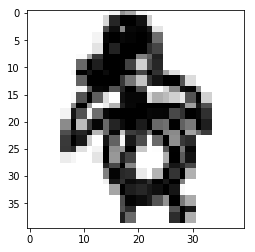

rabbit


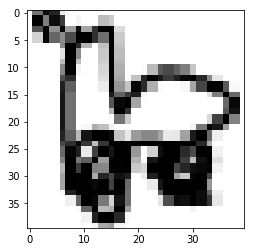

pool


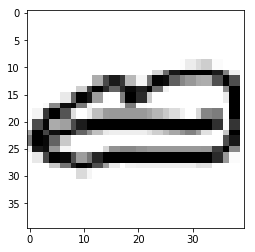

moustache


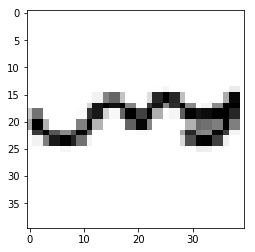

mug


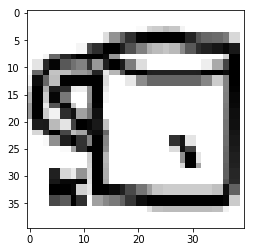

pencil


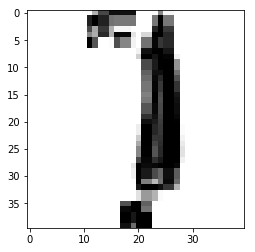

empty


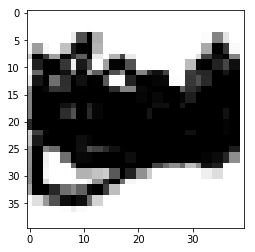

paintbrush


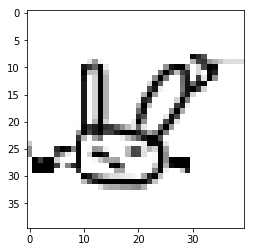

sailboat


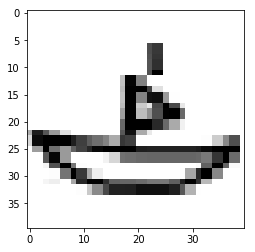

mouth


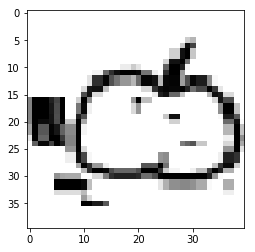

pineapple


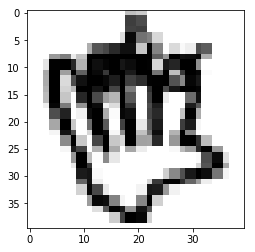

paintbrush


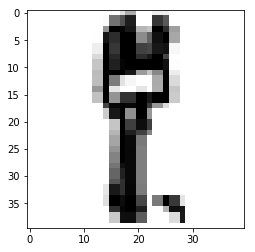

paintbrush


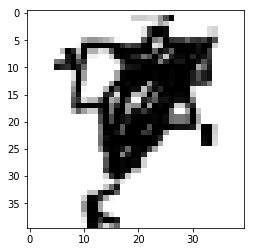

paintbrush


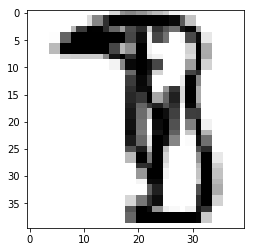

mug


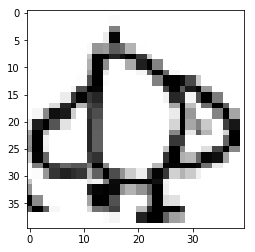

paintbrush


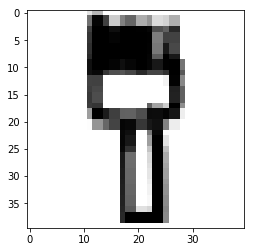

pencil


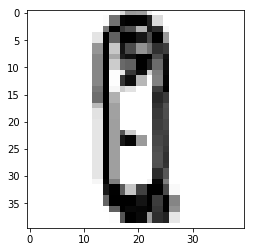

pineapple


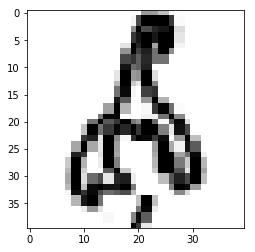

mouth


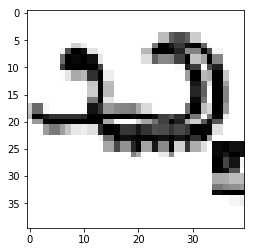

mug


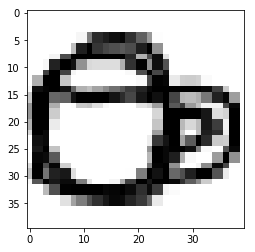

sailboat


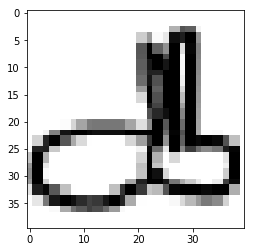

mouth


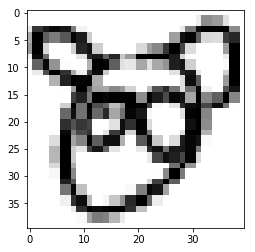

pineapple


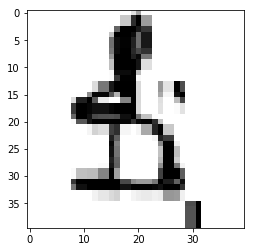

pineapple


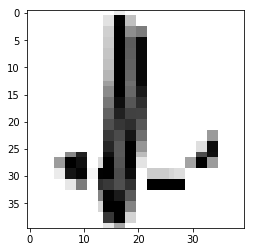

shovel


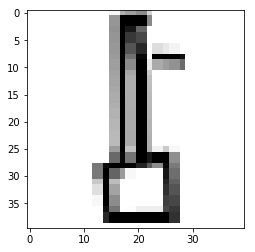

peanut


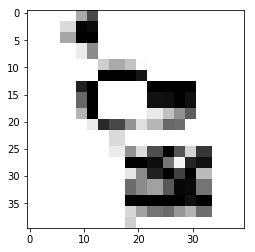

rifle


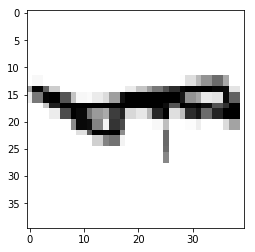

rifle


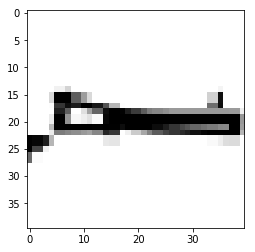

nose


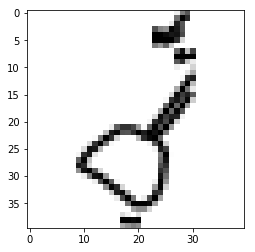

mouth


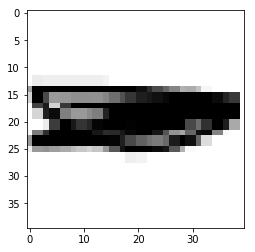

skateboard


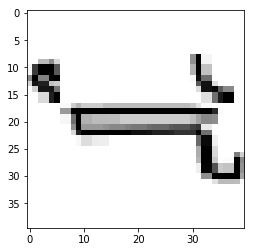

pencil


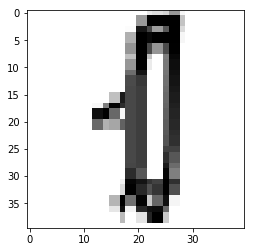

mouth


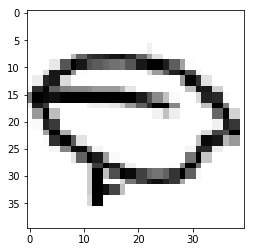

apple


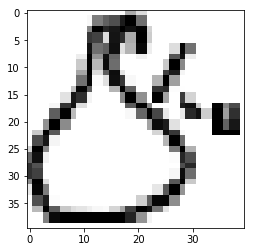

pineapple


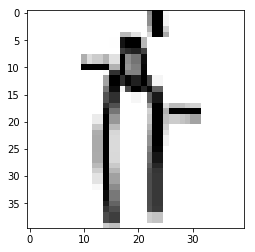

rollerskates


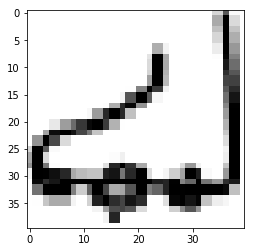

pineapple


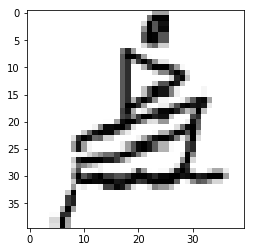

nail


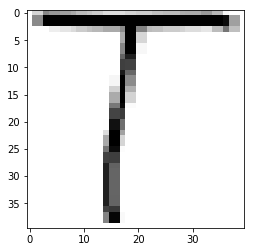

mouth


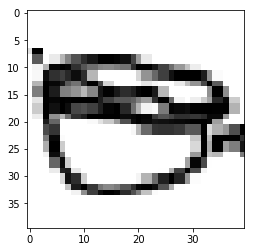

paintbrush


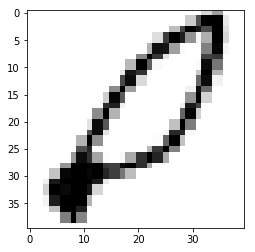

moustache


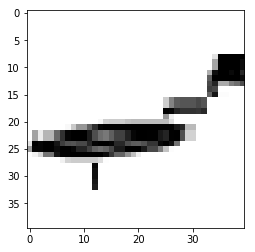

rifle


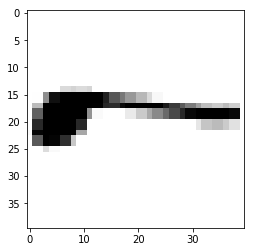

sailboat


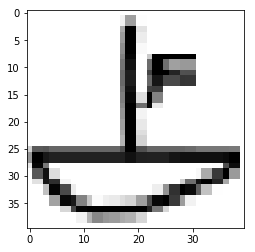

pool


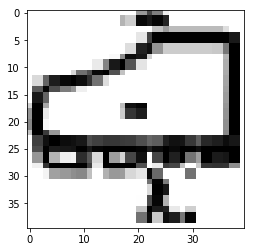

pillow


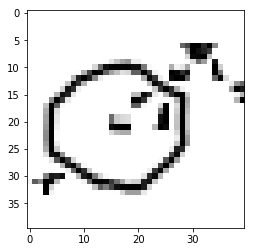

pool


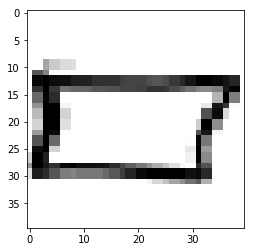

skateboard


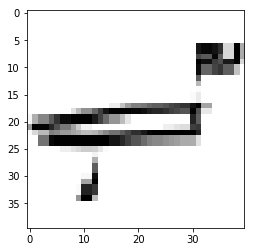

pineapple


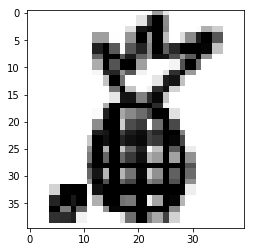

pineapple


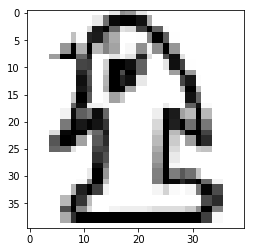

empty


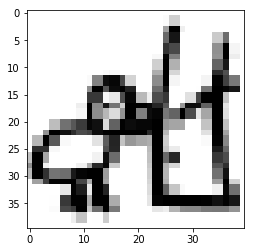

rollerskates


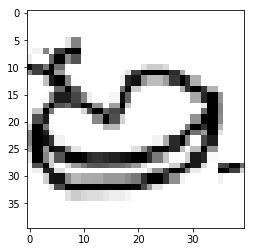

rifle


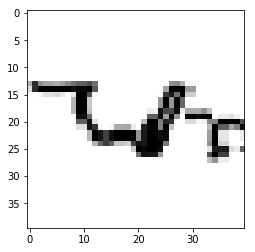

pool


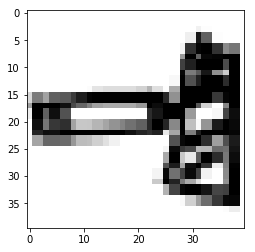

moustache


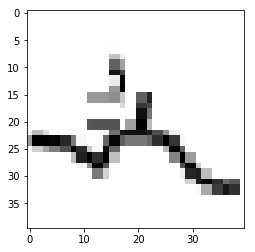

rifle


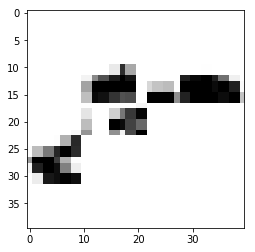

rollerskates


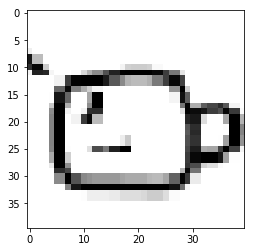

pillow


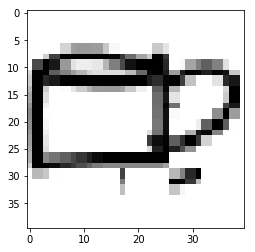

pillow


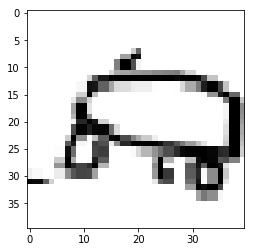

pineapple


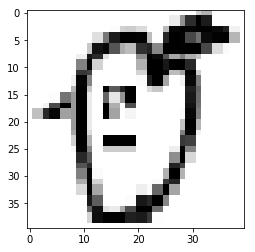

moustache


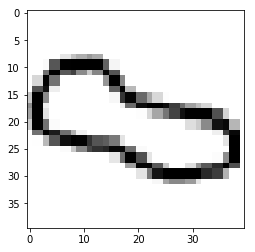

octagon


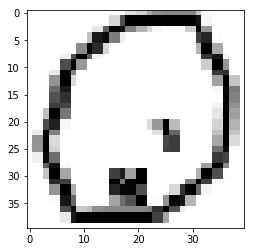

pineapple


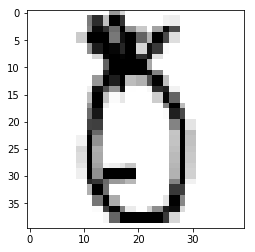

moustache


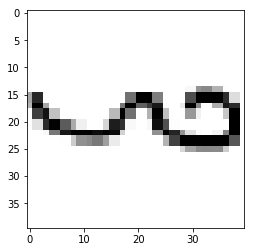

mug


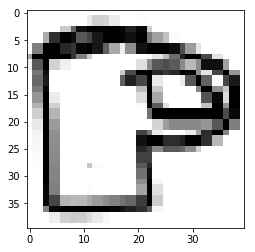

pineapple


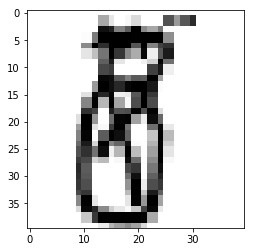

mouth


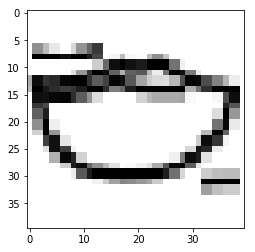

octagon


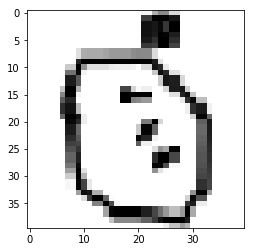

skateboard


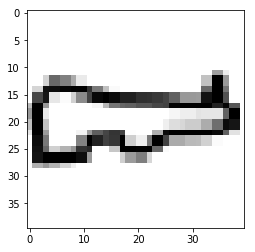

skateboard


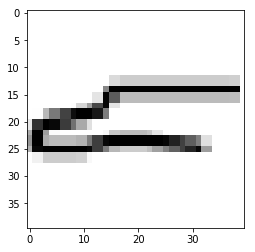

pineapple


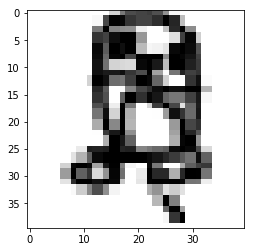

pool


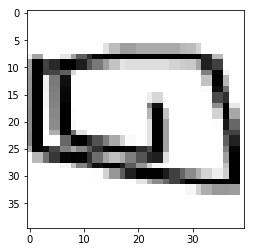

mouth


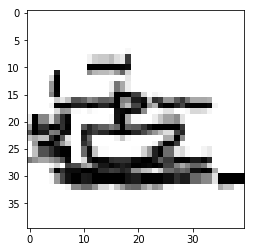

apple


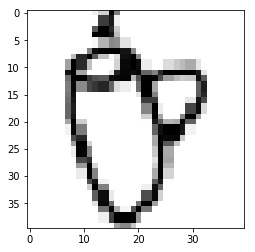

apple


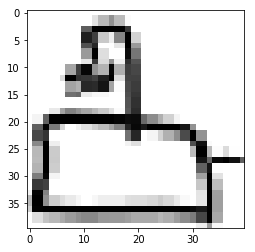

sailboat


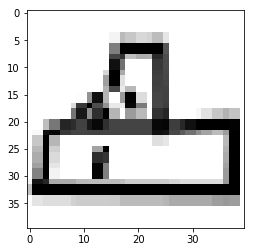

nail


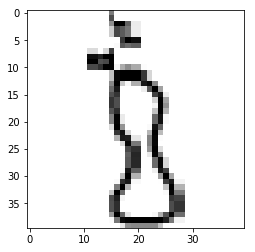

nail


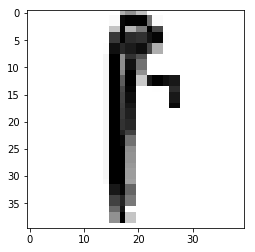

mouth


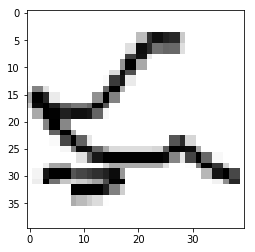

empty


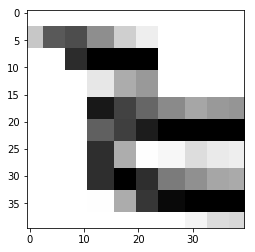

apple


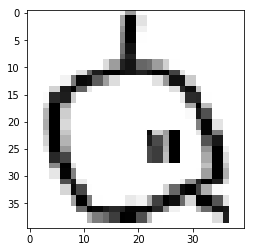

skull


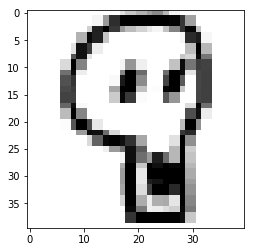

octagon


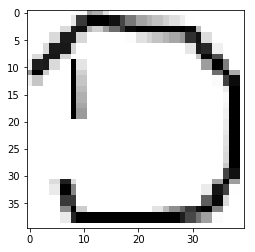

apple


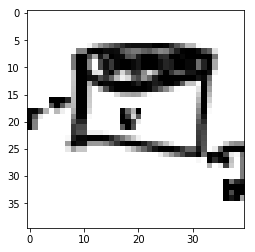

octagon


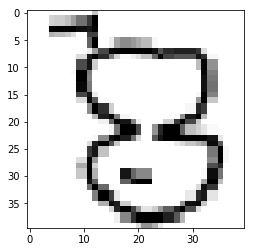

pencil


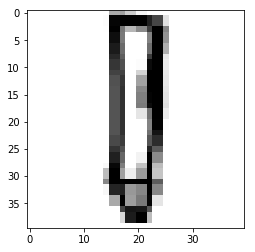

mug


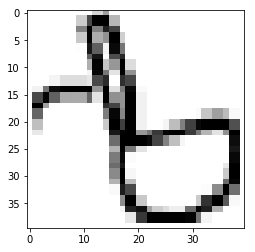

nose


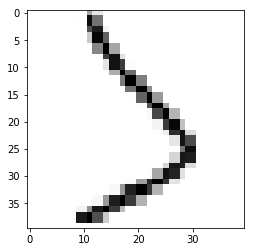

nail


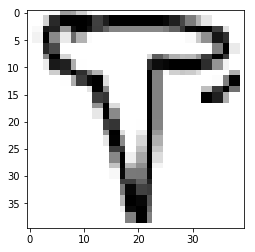

mouth


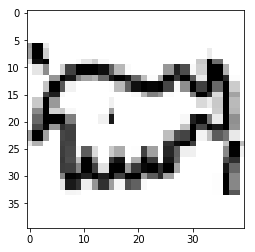

octagon


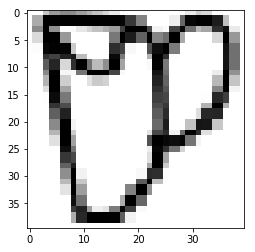

mug


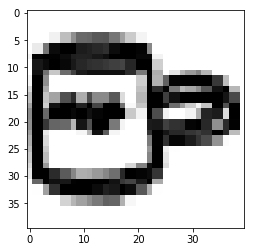

octagon


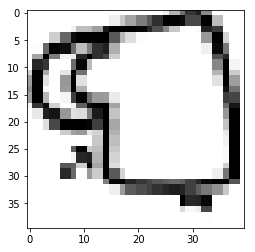

nail


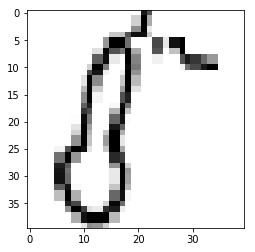

octagon


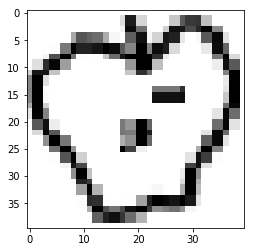

skateboard


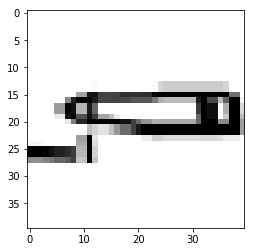

spoon


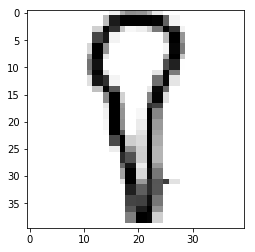

nose


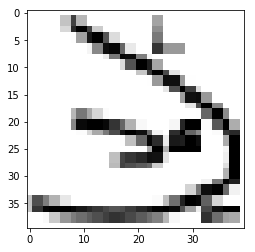

pool


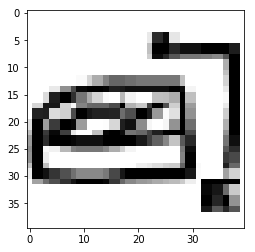

nail


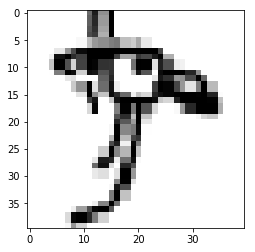

octagon


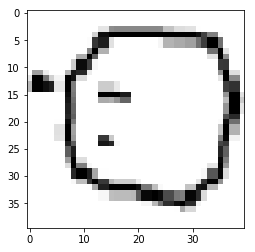

sailboat


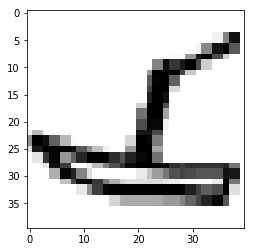

moustache


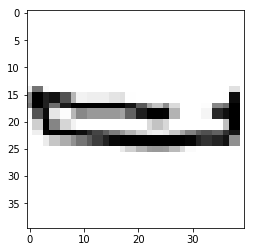

paintbrush


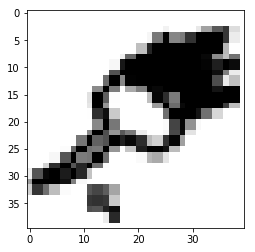

pear


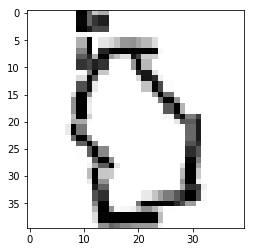

mouth


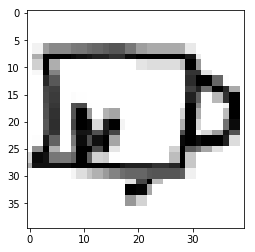

moustache


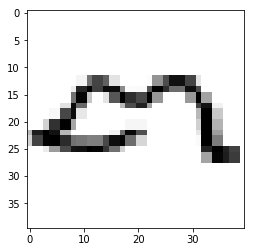

skateboard


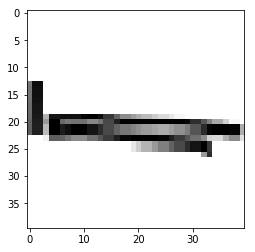

apple


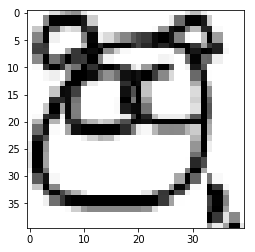

shovel


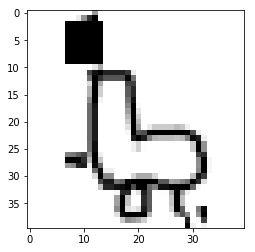

penguin


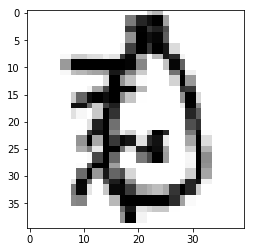

pencil


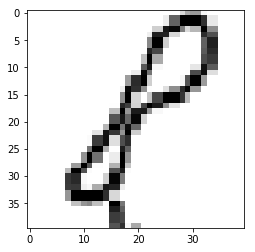

apple


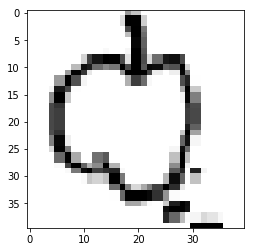

spoon


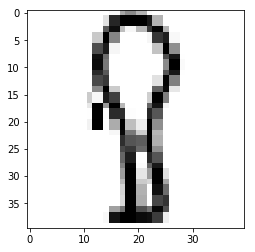

rifle


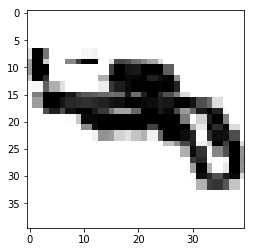

pool


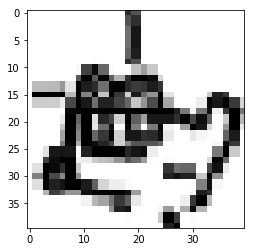

mug


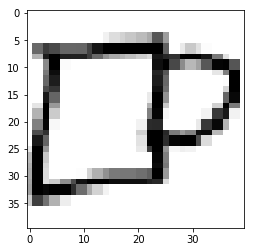

rifle


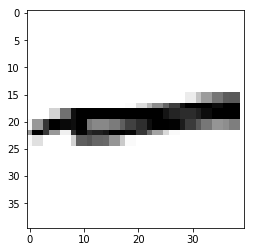

nail


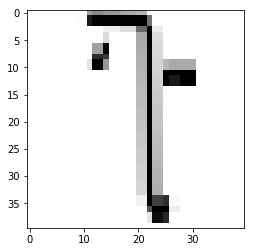

moustache


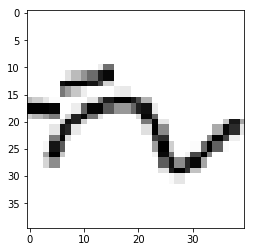

pillow


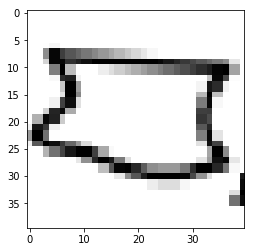

rifle


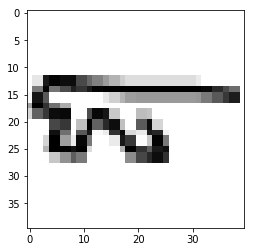

sailboat


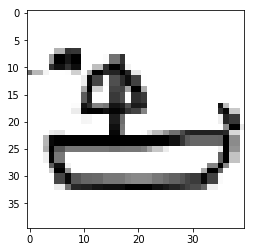

empty


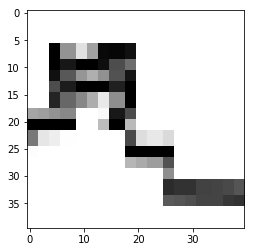

moustache


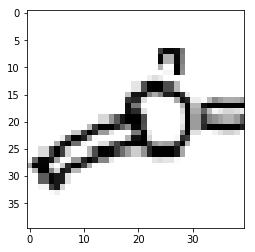

nail


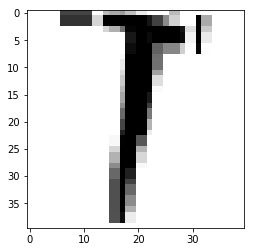

moustache


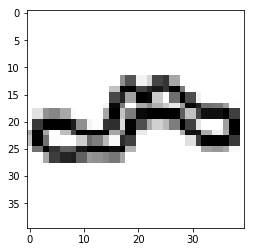

rifle


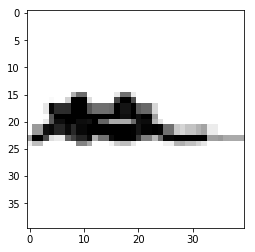

skull


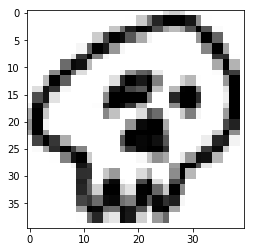

rifle


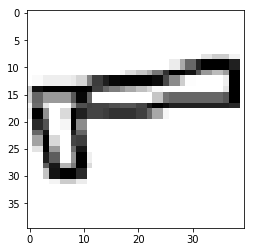

rifle


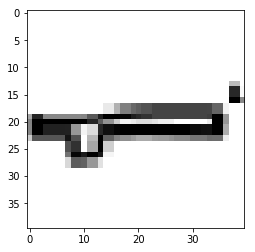

pineapple


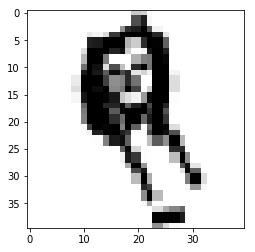

skateboard


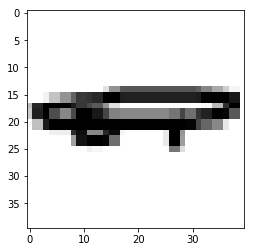

apple


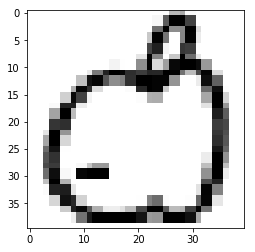

pineapple


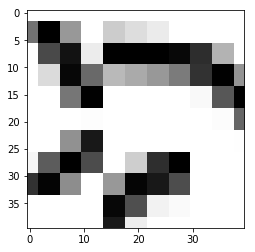

mouth


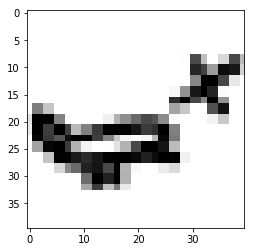

mouth


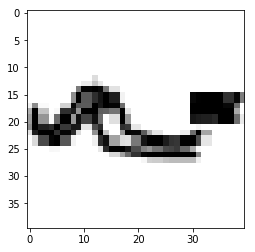

peanut


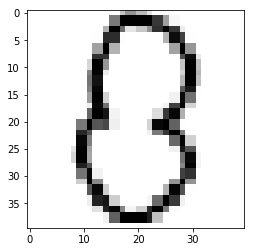

spoon


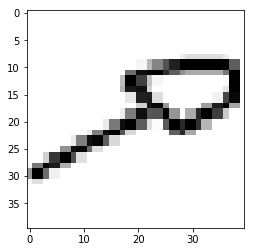

mouth


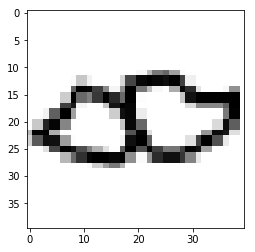

rifle


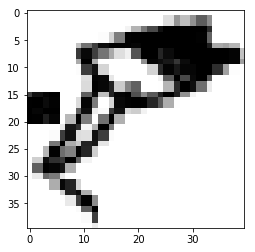

scorpion


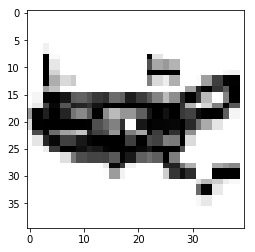

nail


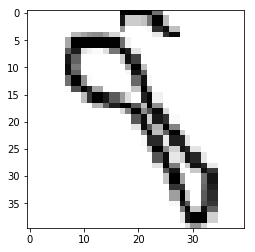

mouth


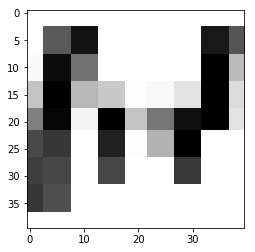

rifle


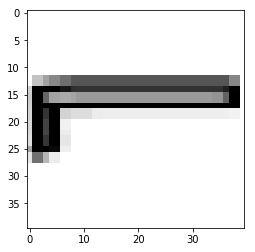

mouth


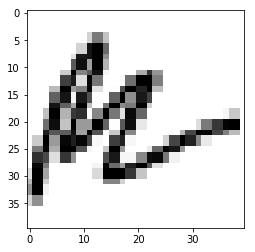

nail


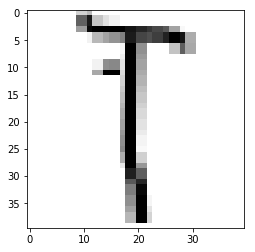

rifle


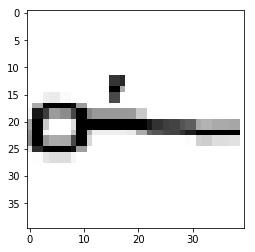

rifle


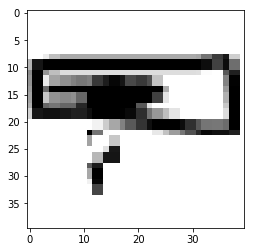

pool


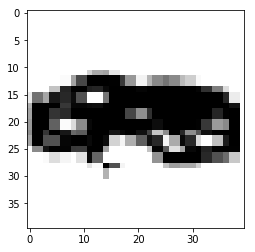

sailboat


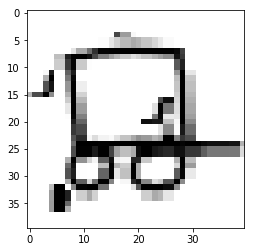

mug


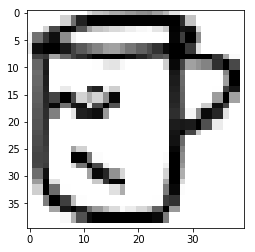

skateboard


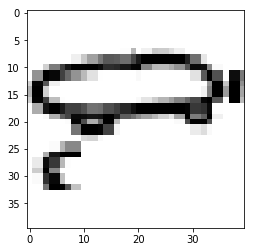

octagon


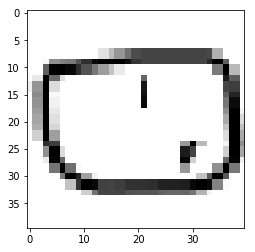

pineapple


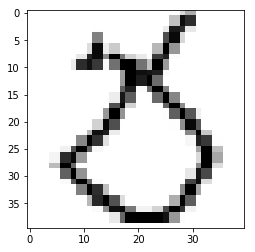

penguin


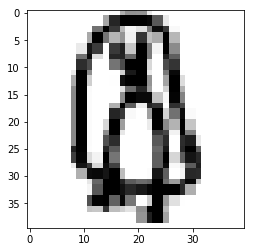

penguin


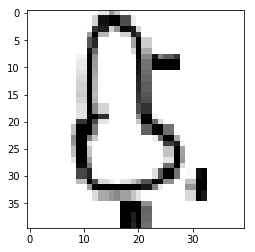

mug


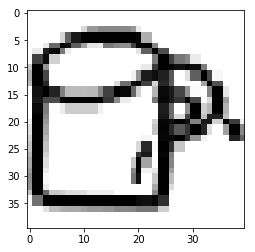

mouth


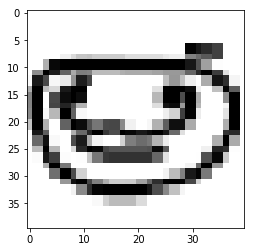

pencil


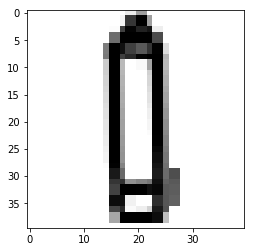

rifle


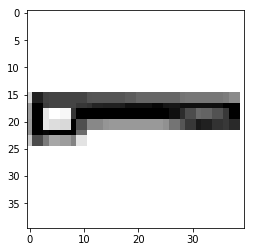

mouth


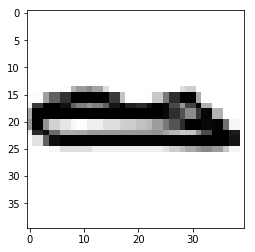

skateboard


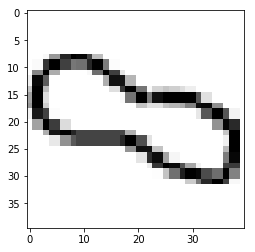

skateboard


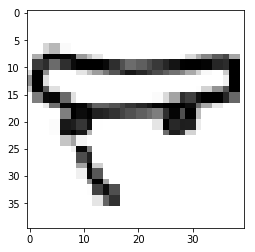

sailboat


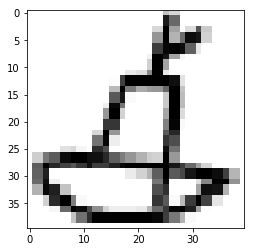

octagon


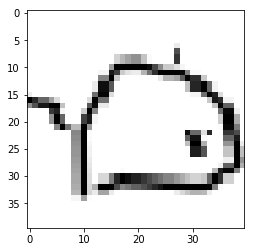

pool


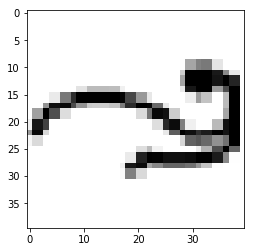

mouth


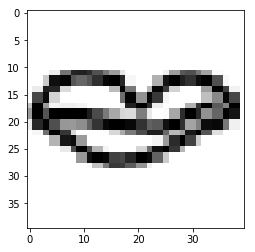

octagon


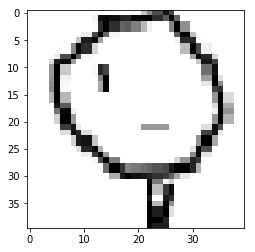

paintbrush


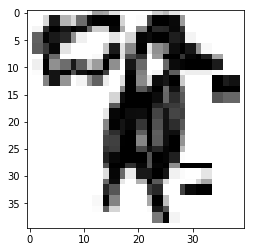

skateboard


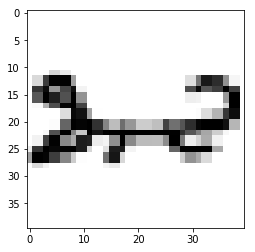

mouth


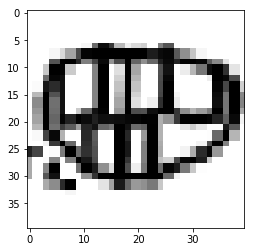

moustache


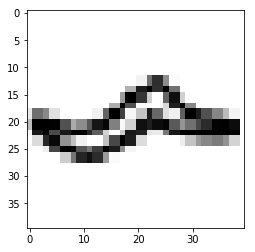

rifle


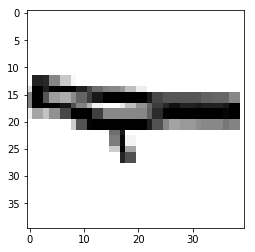

skull


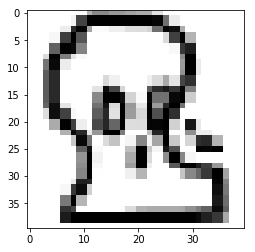

nail


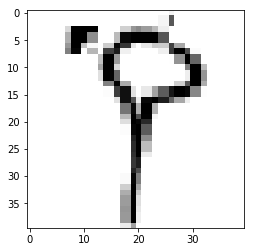

octagon


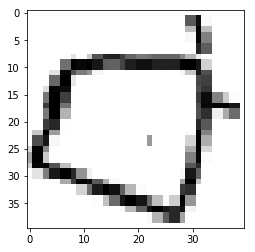

moustache


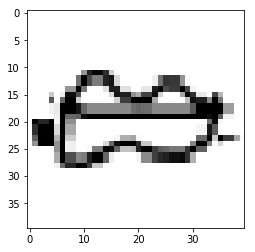

rifle


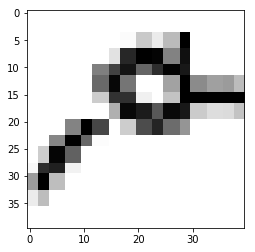

pineapple


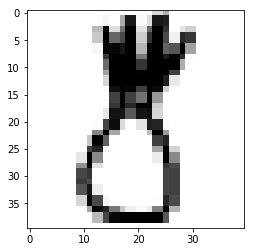

scorpion


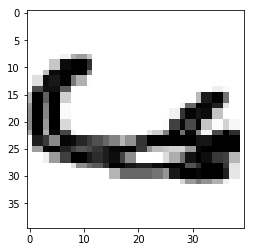

shovel


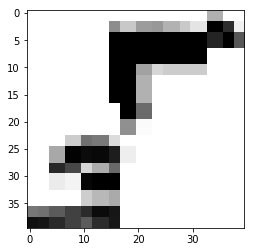

nail


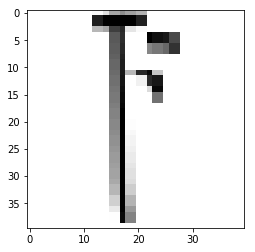

octagon


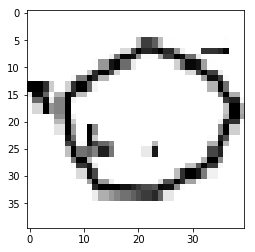

octagon


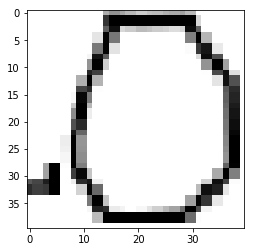

scorpion


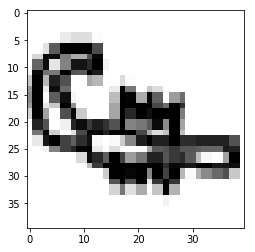

nail


KeyboardInterrupt: 

In [474]:
for i, img in enumerate(preprocessed_kaggle):
    img = img[1].reshape((40,40)).astype(np.uint8)
    print(getCategoryOf(kaggle_predictions[i]))
    plt.imshow(img, cmap='gray_r')
    plt.show()

# Epilogue: Investigating average pixel values for each type of drawing

In [204]:
def average(X, y):
    averageImgs = {}
    for i, img in enumerate(X):
        category = getCategoryOf(y[i])
        if category in averageImgs:
            averageImgs['avg'] += img
            averageImgs[category]['count'] += 1
        else:
            averageImgs[category] = {
                'avg': img,
                'category': category,
                'count': 1,
            }
    for k in averageImgs.keys():
        averageImgs['avg'] /= averageImgs['count']
    return averageImgs

In [205]:
average(XAll[:10], yAll[:10])

NameError: name 'XAll' is not defined

# Preprocess images with bounding box of largest contour

In [109]:
kaggle_images = np.load(VALID_IMG_PATH, encoding='bytes')
preprocessImages('./data/train_preprocessed_boundingbox', images, noiseRemoveType='bounding_box', contour_type='largest') 
preprocessImages('./data/kaggle_preprocessed_boundingbox', kaggle_images, noiseRemoveType='bounding_box', contour_type='largest') 

In [ ]:
preprocessImages('./data/train_preprocessed_boundingbox', images, noiseRemoveType='bounding_box', contour_type='largest') 
